In [49]:
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

In [ ]:
# Caricamento file
PATH = "C:/Users/nicde/OneDrive/Desktop/Università/Ancona/DS/Data-Science/datasets/GeneratedLabelledFlows/TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv"

df = pd.read_csv(PATH)

# Pulisce i nomi delle colonne rimuovendo spazi all'inizio e alla fine
df.columns = df.columns.str.strip()

# Assicura che Timestamp sia in formato datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Crea una colonna che raggruppa per Ora e Minuto
df['Time_Key'] = df['Timestamp'].dt.strftime('%H:%M')

# Conta gli attacchi per ogni minuto reale della giornata
attacchi_per_minuto = df[df['Label'] != 'BENIGN'].groupby('Time_Key').size()

if attacchi_per_minuto.empty:
    print("Nessun attacco trovato")
else:
    print("Distribuzione attacchi per minuto:")
    print(attacchi_per_minuto)

Distribuzione attacchi per minuto:
Time_Key
09:34     1
09:35     1
10:04    12
10:05    12
10:06    10
         ..
12:54     7
12:56     7
12:57     5
12:58     2
12:59     7
Length: 163, dtype: int64


In [ ]:
# Filtra solo il traffico malevolo
df_attacks = df[df['Label'] != 'BENIGN']

# Trova il minuto con il valore massimo
counts = df_attacks['Time_Key'].value_counts()
max_minute = counts.idxmax()
max_value = counts.max()

print(f"Il picco massimo di attacchi è al minuto {max_minute} con {max_value} flussi.")

Il picco massimo di attacchi è al minuto 10:44 con 77 flussi.


In [ ]:
# Definiamo il range 
minuti_di_interesse = ["10:39", "10:40", "10:41", "10:42", "10:43", "10:44", "10:45", "10:46", "10:47", "10:48", "10:49"]

# Filtra il dataframe per questo intervallo
df_window = df[df['Time_Key'].isin(minuti_di_interesse)]

# Conta Benign vs Attack per ogni minuto
window_stats = df_window.groupby(['Time_Key', 'Label']).size().unstack(fill_value=0)

# Riordina i minuti cronologicamente
window_stats = window_stats.reindex(minuti_di_interesse)

print("Statistiche del traffico nella finestra temporale selezionata:")
print(window_stats)


Statistiche del traffico nella finestra temporale selezionata:
Label     BENIGN  Bot
Time_Key             
10:39       1514   34
10:40        257   10
10:41       1237    6
10:42        240   37
10:43        243   69
10:44        742   77
10:45        227   75
10:46        607   68
10:47        232   14
10:48        419   56
10:49        133   70


In [53]:
# Filtra il dataset per la finestra temporale del picco
df_botnet = df[(df['Time_Key'] >= '10:39') & (df['Time_Key'] <= '10:49')].copy()

print(f"Numero di flussi estratti: {len(df_botnet)}")
print(df_botnet['Label'].value_counts())

Numero di flussi estratti: 6367
Label
BENIGN    5851
Bot        516
Name: count, dtype: int64


In [ ]:
# Definiamo l'inizio e la fine basandoci sui picchi trovati
start_time_attack = df['Timestamp'].dt.normalize() + pd.Timedelta(hours=10, minutes=39)
end_time_attack = start_time_attack + pd.Timedelta(minutes=11)

#Filtra il DataFrame
df_11min = df[
    (df['Timestamp'] >= start_time_attack) & 
    (df['Timestamp'] < end_time_attack)
].copy()

if "Label" in df_11min.columns:
    print("\nDistribuzione etichette nella finestra scelta:")
    print(df_11min["Label"].value_counts())


Distribuzione etichette nella finestra scelta:
Label
BENIGN    5851
Bot        516
Name: count, dtype: int64


In [ ]:
# Estrazione archi diretti (flow direction: Src IP -> Dst IP)
edges = df_11min[["Source IP", "Destination IP"]].dropna()

# Aggregazione: conteggio flussi per coppia (Src IP, Dst IP)
edges_w = (
    edges.groupby(["Source IP", "Destination IP"])
         .size()
         .reset_index(name="weight")
)

# Lista IP unici (sorgenti e destinazioni)
ips = pd.unique(edges_w[["Source IP", "Destination IP"]].values.ravel())

# Mappa IP -> ID intero
ip_to_id = {ip: i for i, ip in enumerate(ips)}

# Applica mappatura
edges_w["src_id"] = edges_w["Source IP"].map(ip_to_id)
edges_w["dst_id"] = edges_w["Destination IP"].map(ip_to_id)

mapping_df = pd.DataFrame({"ip": list(ip_to_id.keys()), "id": list(ip_to_id.values())})
mapping_df.to_csv("ip_id_mapping_botnet_11m.csv", index=False)

In [56]:
# Salvataggio file di archi pesati
EDGE_TXT = "cic_botnet_11m_edges_weighted.txt"

edges_w[["src_id", "dst_id", "weight"]].to_csv(
    EDGE_TXT,
    sep=" ",
    index=False,
    header=False
)

In [ ]:
# Creazione del grafo con NetworkX
data = pd.read_csv(EDGE_TXT, sep=" ", header=None, names=["src", "target", "weight"])

G = nx.DiGraph()
for _, r in data.iterrows():
    G.add_edge(int(r["src"]), int(r["target"]), weight=int(r["weight"]))

In [ ]:
# Analisi del grafo
def analizza_grafo_diretto_pesato(G: nx.DiGraph, weight_attr: str = "weight"):
    """
    Analisi base per grafo DIRETTO e PESATO.
    Per distanze (raggio/diametro) si usa un costo inverso: cost = 1/weight.
    """
    if not isinstance(G, (nx.DiGraph, nx.MultiDiGraph)):
        raise TypeError("Questa funzione è pensata per grafi diretti (DiGraph/MultiDiGraph).")

    # Nodi e archi
    n_nodi = G.number_of_nodes()
    n_archi = G.number_of_edges()

    # Densità
    densita = nx.density(G)

    # Connettività debole vs forte
    weakly = nx.is_weakly_connected(G) if n_nodi > 0 else False
    strongly = nx.is_strongly_connected(G) if n_nodi > 0 else False

    # Clustering
    G_u = G.to_undirected()
    clustering_medio = nx.average_clustering(G_u)

    # Raggio/diametro/periferia: calcolabili solo su un grafo connesso (qui: componente connessa massima)
    # e con una metrica di distanza coerente con i pesi:
    # weight = numero di flussi (forza) -> cost = 1/weight (più flussi => distanza minore)
    raggio = diametro = periferia = None

    if n_nodi > 0 and G_u.number_of_edges() > 0:
        # Componente connessa più grande 
        largest_cc_nodes = max(nx.connected_components(G_u), key=len)
        H = G_u.subgraph(largest_cc_nodes).copy()

        # Costruzione attributo 'cost' = 1/weight
        for u, v, data in H.edges(data=True):
            w = data.get(weight_attr, 1)
            try:
                w = float(w)
            except Exception:
                w = 1.0
            data["cost"] = (1.0 / w) if w > 0 else math.inf

        # Se la componente ha almeno 2 nodi si possono calcolare eccentricità/raggio/diametro
        if H.number_of_nodes() >= 2:
            # eccentricity usa 'distance' come nome parametro
            ecc = nx.eccentricity(H, weight="cost")
            raggio = min(ecc.values())
            diametro = max(ecc.values())
            periferia = [n for n, e in ecc.items() if e == diametro]

    # Stampa risultati
    print(f"Numero di nodi: {n_nodi}")
    print(f"Numero di archi: {n_archi}")
    print(f"Densità (diretto): {densita:.6f}")
    print(f"Connesso (debole / weakly): {weakly}")
    print(f"Connesso (forte / strongly): {strongly}")
    print(f"Average clustering coefficient (su versione non diretta): {clustering_medio:.6f}")

    if raggio is not None:
        print("Raggio/Diametro/Periferia calcolati sulla componente connessa più grande (versione non diretta),")
        print("usando cost=1/weight (più flussi => distanza minore).")
        print(f"Raggio: {raggio}")
        print(f"Diametro: {diametro}")
        print(f"Periferia: {periferia}")
    else:
        print("Raggio, diametro e periferia non calcolati (grafo vuoto/non connesso o componente troppo piccola).")


In [59]:
analizza_grafo_diretto_pesato(G, weight_attr="weight")

Numero di nodi: 446
Numero di archi: 941
Densità (diretto): 0.004741
Connesso (debole / weakly): False
Connesso (forte / strongly): False
Average clustering coefficient (su versione non diretta): 0.006730
Raggio/Diametro/Periferia calcolati sulla componente connessa più grande (versione non diretta),
usando cost=1/weight (più flussi => distanza minore).
Raggio: 1.0769230769230769
Diametro: 2.132055711517431
Periferia: [24, 30, 43, 61, 64, 65, 73, 80, 81, 97, 99, 102, 107, 109, 110, 111, 122, 123, 228, 318, 320, 321, 326, 333, 337, 339, 341, 344, 345, 346, 352, 353, 354, 359, 361, 364, 365, 371, 372, 374, 377, 381, 383, 387, 388, 390, 397, 400, 401, 403, 406, 408, 423, 424, 426, 431, 437]


Nodi etichettati come attaccanti: {58: 'Attack', 139: 'Attack', 16: 'Attack', 8: 'Attack', 1: 'Attack', 138: 'Attack'}


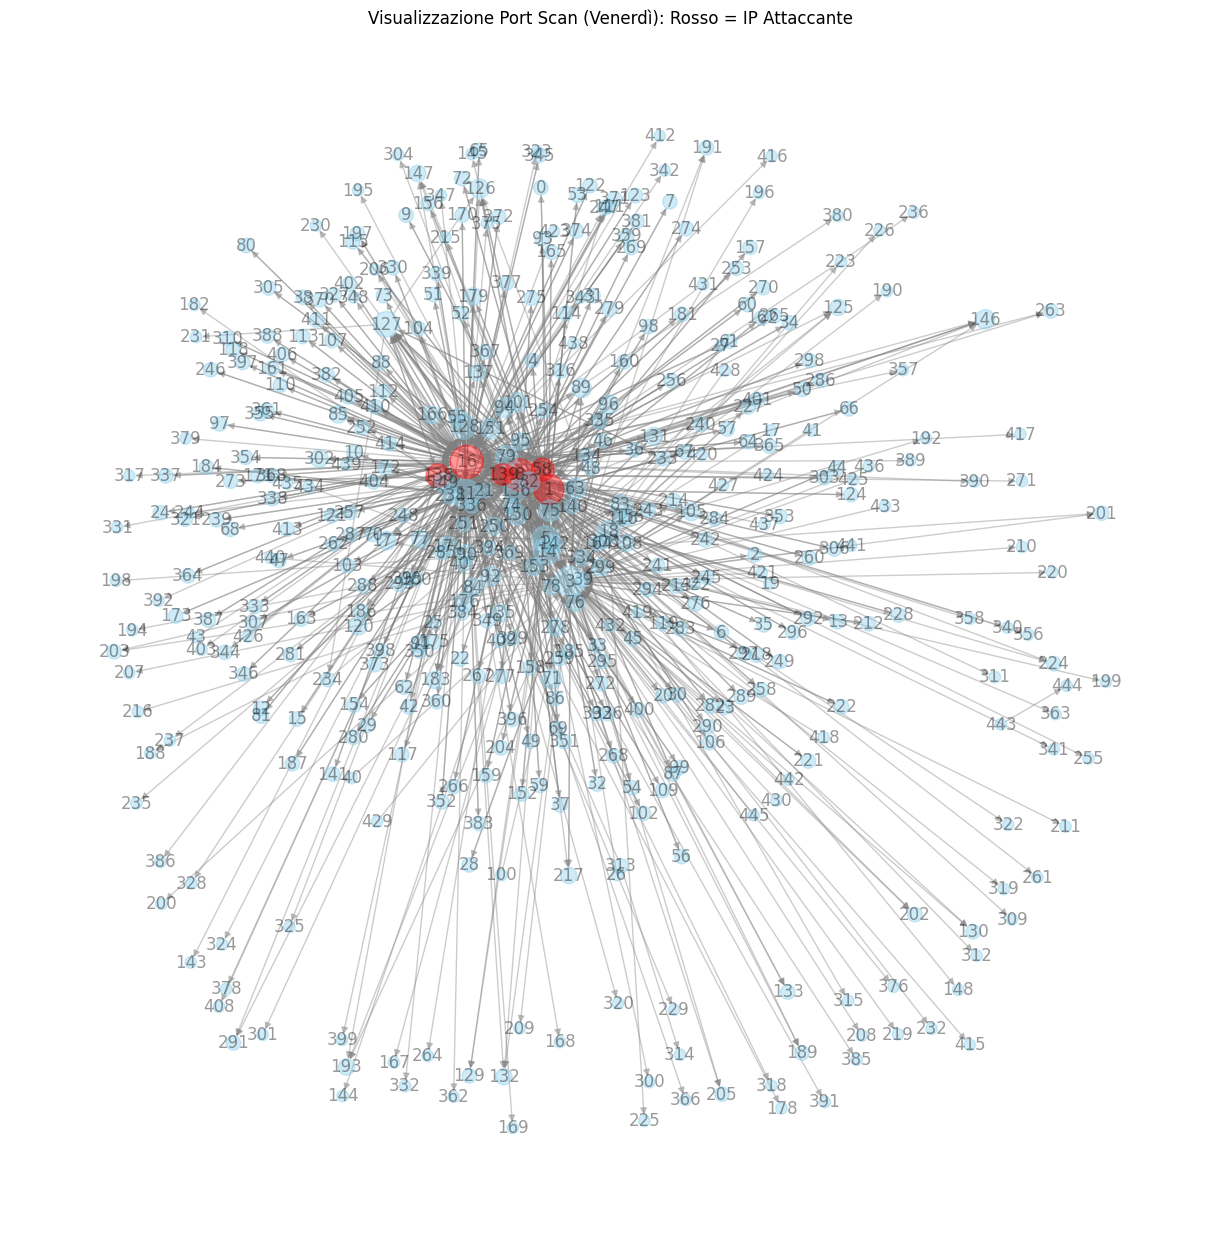

In [ ]:
# Identifica l'IP dell'attaccante usando la mappa IP->ID
node_labels = {}
for _, row in df_11min.iterrows():
    label_pulita = str(row['Label']).strip()
    if label_pulita != 'BENIGN':
        ip_attaccante = row['Source IP']
        if ip_attaccante in ip_to_id:
            id_attaccante = ip_to_id[ip_attaccante]
            node_labels[id_attaccante] = 'Attack'
            
print(f"Nodi etichettati come attaccanti: {node_labels}")

# Creazione della lista colori basata sugli ID
colors = []
contatore_rossi = 0
for node in G.nodes():
    if node in node_labels:
        colors.append('red')
        contatore_rossi += 1
    else:
        colors.append('skyblue')


# Visualizzazione 
d = dict(G.degree)
node_sizes = [np.log1p(v) * 100 for v in d.values()]

pos = nx.spring_layout(G, k=0.15, iterations=20) 

plt.figure(figsize=(12, 12))
nx.draw(G, pos, 
        node_size=node_sizes, 
        node_color=colors, 
        with_labels=True, # Metti True se vuoi vedere l'ID numerico dell'attaccante
        edge_color='gray',
        alpha=0.4)

plt.title("Visualizzazione Port Scan (Venerdì): Rosso = IP Attaccante")
plt.show()

Nodi nella componente d'attacco: 444
Archi nella componente d'attacco: 940


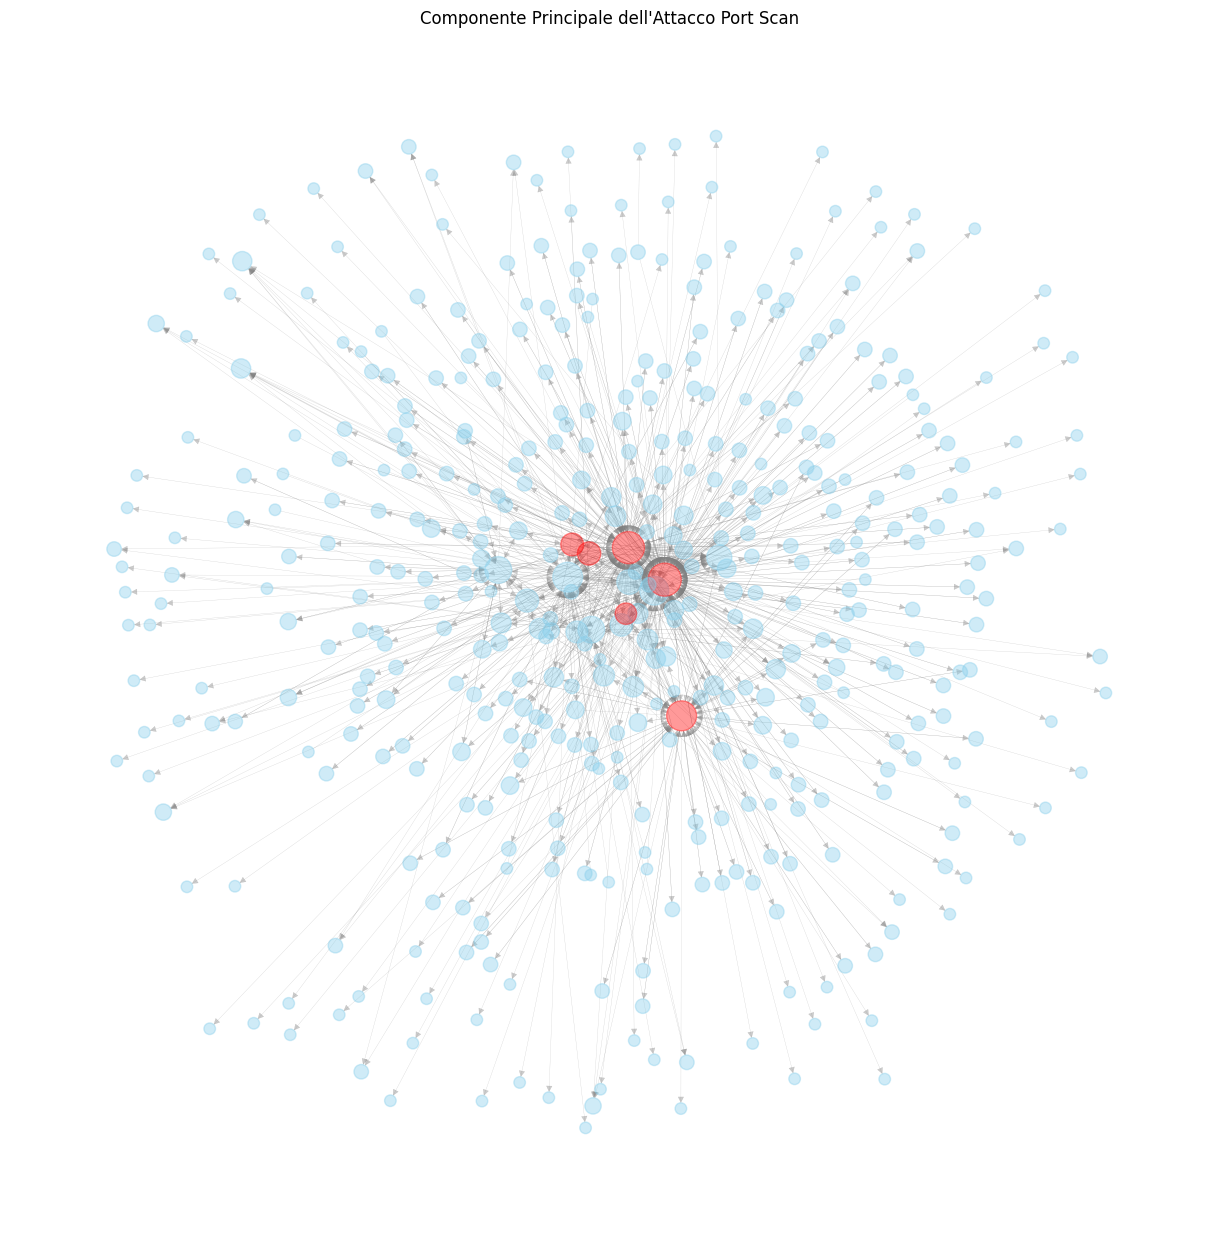

In [ ]:
# Estrae la componente debolmente connessa più grande
largest_wcc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_wcc).copy()

print(f"Nodi nella componente d'attacco: {H.number_of_nodes()}")
print(f"Archi nella componente d'attacco: {H.number_of_edges()}")

# Ricalcola i colori solo per i nodi presenti in H
colors_H = []
for node in H.nodes():
    if node in node_labels: # node_labels contiene gli ID degli attaccanti
        colors_H.append('red')
    else:
        colors_H.append('skyblue')

# Ricalcola le dimensioni solo per i nodi in H
d_H = dict(H.degree)
node_sizes_H = [np.log1p(v) * 100 for v in d_H.values()]

# Visualizzazione di H
pos = nx.spring_layout(H, k=0.15, iterations=20)
plt.figure(figsize=(12, 12))
nx.draw(H, pos, 
        node_size=node_sizes_H, 
        node_color=colors_H, 
        edge_color='gray',
        alpha=0.4,
        width=0.2)
plt.title("Componente Principale dell'Attacco Port Scan")
plt.show()

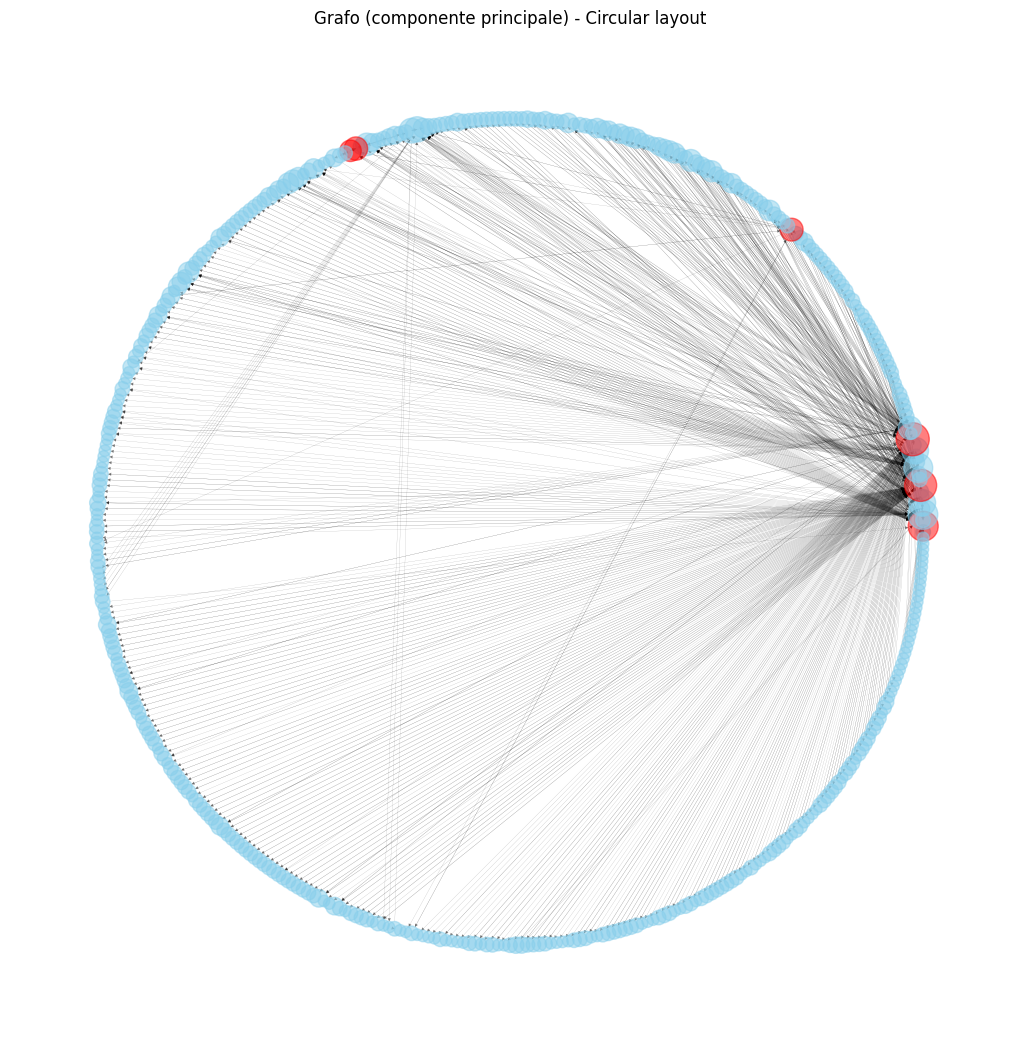

In [ ]:
# Visualizzazione circular 
pos = nx.circular_layout(H.to_undirected())

plt.figure(figsize=(10, 10))
nx.draw(H, pos, 
        with_labels=False, 
        node_size=node_sizes_H, # Usa le dimensioni pesate sul grado
        node_color=colors_H,    # Usa la lista con l'attaccante rosso
        arrows=True, 
        arrowsize=5,            
        width=0.1,              # Archi sottili per evitare il "muro" di colore
        alpha=0.5)
plt.title("Grafo (componente principale) - Circular layout")
plt.axis("off")
plt.show()

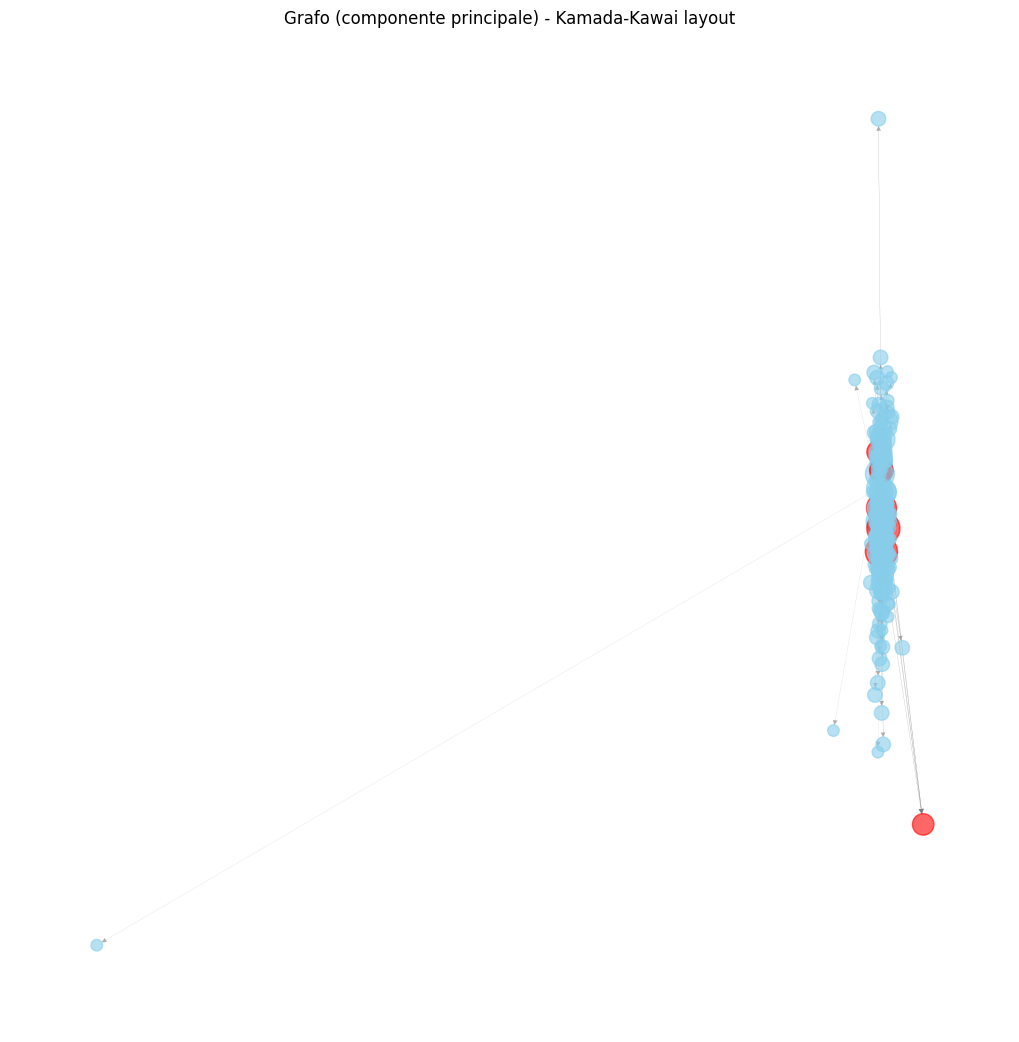

In [ ]:
# Visualizzazione kamada-kawai
pos = nx.kamada_kawai_layout(H.to_undirected())

plt.figure(figsize=(10, 10))
nx.draw(H, pos, 
        with_labels=False, 
        node_size=node_sizes_H, 
        node_color=colors_H,    # Rosso per l'attaccante
        arrows=True, 
        arrowsize=8, 
        edge_color='gray',
        width=0.1,              # Molto sottile per gestire i grandi numeri
        alpha=0.6)
plt.title("Grafo (componente principale) - Kamada-Kawai layout")
plt.axis("off")
plt.show()

In [ ]:
# Costruisce un grafo non diretto per closeness/betweenness/eigenvector "stabili" 
U = H.to_undirected()

# Crea 'cost' = 1/weight (weight = numero flussi => più flussi = più vicinanza)
for u, v, data in U.edges(data=True):
    w = data.get("weight", 1)
    try:
        w = float(w)
    except Exception:
        w = 1.0
    data["cost"] = (1.0 / w) if w > 0 else math.inf

# Centralità
# Degree: su grafo diretto ha più senso separare in/out 
in_deg_cent = {n: d/(H.number_of_nodes()-1) for n, d in H.in_degree()}
out_deg_cent = {n: d/(H.number_of_nodes()-1) for n, d in H.out_degree()}
degree_centrality = nx.degree_centrality(U)

# Closeness e betweenness: usa cost come distanza
try:
    closeness_centrality = nx.closeness_centrality(U, distance="cost")
except TypeError:
    closeness_centrality = nx.closeness_centrality(U)

betweenness_centrality = nx.betweenness_centrality(U, weight="cost")

# Eigenvector: su grafo non diretto è più robusta; i pesi qui puoi usarli come intensità (weight="weight")
try:
    eigenvector_centrality = nx.eigenvector_centrality(U, weight="weight", max_iter=2000)
except nx.PowerIterationFailedConvergence:
    eigenvector_centrality = nx.eigenvector_centrality_numpy(U, weight="weight")

# DataFrame 
centrality_df = pd.DataFrame({
    "Node": list(U.nodes),
    "In-Degree Centrality": [in_deg_cent[n] for n in U.nodes],
    "Out-Degree Centrality": [out_deg_cent[n] for n in U.nodes],
    "Degree Centrality": [degree_centrality[n] for n in U.nodes],
    "Closeness Centrality": [closeness_centrality[n] for n in U.nodes],
    "Betweenness Centrality": [betweenness_centrality[n] for n in U.nodes],
    "Eigenvector Centrality": [eigenvector_centrality[n] for n in U.nodes]
})

centrality_sorted_df = centrality_df.copy()
centrality_sorted_df["Node"] = centrality_sorted_df["Node"].astype(str)

# Ordinamenti
degree_sorted = centrality_sorted_df.sort_values("Degree Centrality", ascending=False)
print("degree_sorted done")

closeness_sorted = centrality_sorted_df.sort_values("Closeness Centrality", ascending=False)
print("closeness_sorted done")

betweenness_sorted = centrality_sorted_df.sort_values("Betweenness Centrality", ascending=False)
print("betweenness_sorted done")

eigenvector_sorted = centrality_sorted_df.sort_values("Eigenvector Centrality", ascending=False)
print("eigenvector_sorted done")

# anche per in/out-degree
in_degree_sorted = centrality_sorted_df.sort_values("In-Degree Centrality", ascending=False)
print("in_degree_sorted done")

out_degree_sorted = centrality_sorted_df.sort_values("Out-Degree Centrality", ascending=False)
print("out_degree_sorted done")

# Stampa top/bottom 5
print("Top 5 Degree Centrality:\n", degree_sorted.head(), "\n")
print("Bottom 5 Degree Centrality:\n", degree_sorted.tail(), "\n")

print("Top 5 Closeness Centrality:\n", closeness_sorted.head(), "\n")
print("Bottom 5 Closeness Centrality:\n", closeness_sorted.tail(), "\n")

print("Top 5 Betweenness Centrality:\n", betweenness_sorted.head(), "\n")
print("Bottom 5 Betweenness Centrality:\n", betweenness_sorted.tail(), "\n")

print("Top 5 Eigenvector Centrality:\n", eigenvector_sorted.head(), "\n")
print("Bottom 5 Eigenvector Centrality:\n", eigenvector_sorted.tail(), "\n")

# top/bottom in/out-degree
print("Top 5 In-Degree Centrality:\n", in_degree_sorted.head(), "\n")
print("Top 5 Out-Degree Centrality:\n", out_degree_sorted.head(), "\n")

degree_sorted done
closeness_sorted done
betweenness_sorted done
eigenvector_sorted done
in_degree_sorted done
out_degree_sorted done
Top 5 Degree Centrality:
    Node  In-Degree Centrality  Out-Degree Centrality  Degree Centrality  \
16   16              0.300226               0.379233           0.404063   
8     8              0.216704               0.264108           0.264108   
3     3              0.115124               0.112867           0.171558   
1     1              0.115124               0.124153           0.128668   
11   11              0.074492               0.099323           0.099323   

    Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  
16              1.592865                0.559036                0.005383  
8               1.615690                0.666071                0.337622  
3               1.593197                0.248496                0.069064  
1               1.573887                0.153850                0.004697  
11            

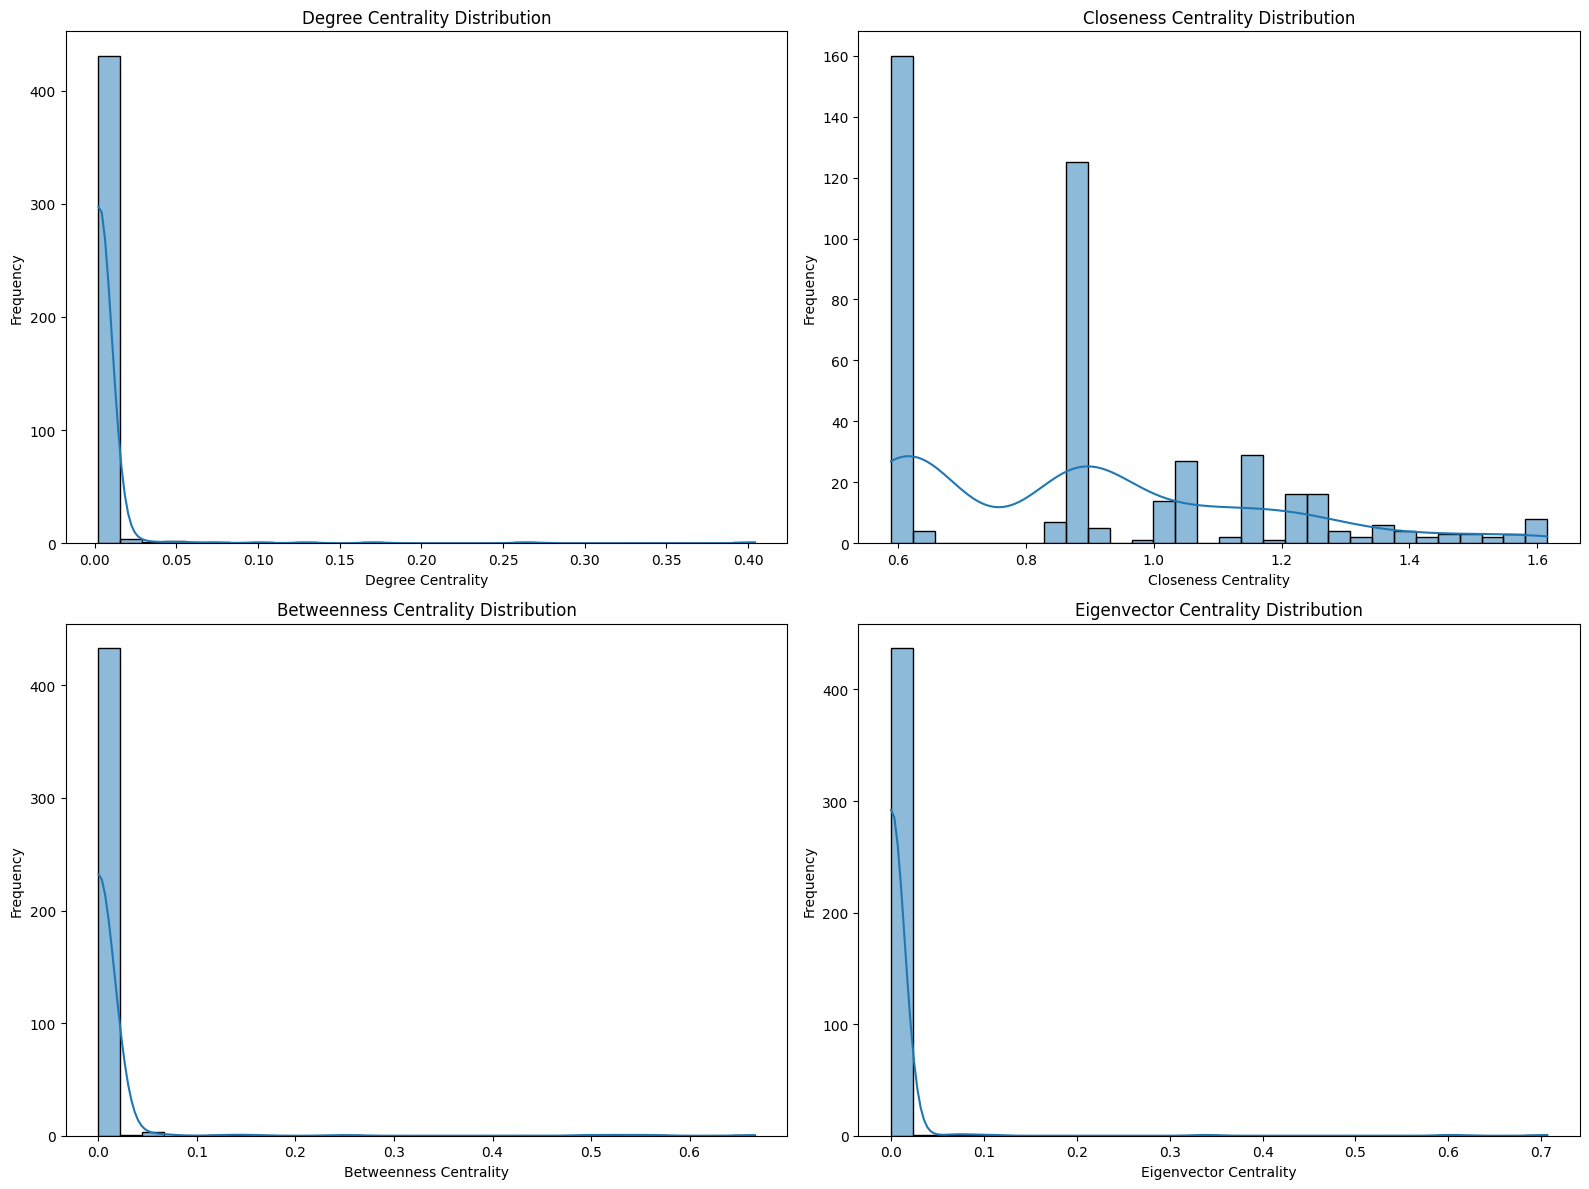

In [ ]:
plt.figure(figsize=(16, 12))

# Degree Centrality
plt.subplot(2, 2, 1)
sns.histplot(
    degree_sorted["Degree Centrality"],
    kde=True,
    bins=30
)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")

# Closeness Centrality
plt.subplot(2, 2, 2)
sns.histplot(
    closeness_sorted["Closeness Centrality"],
    kde=True,
    bins=30
)
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")

# Betweenness Centrality
plt.subplot(2, 2, 3)
sns.histplot(
    betweenness_sorted["Betweenness Centrality"],
    kde=True,
    bins=30
)
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")

# Eigenvector Centrality
plt.subplot(2, 2, 4)
sns.histplot(
    eigenvector_sorted["Eigenvector Centrality"],
    kde=True,
    bins=30
)
plt.title("Eigenvector Centrality Distribution")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

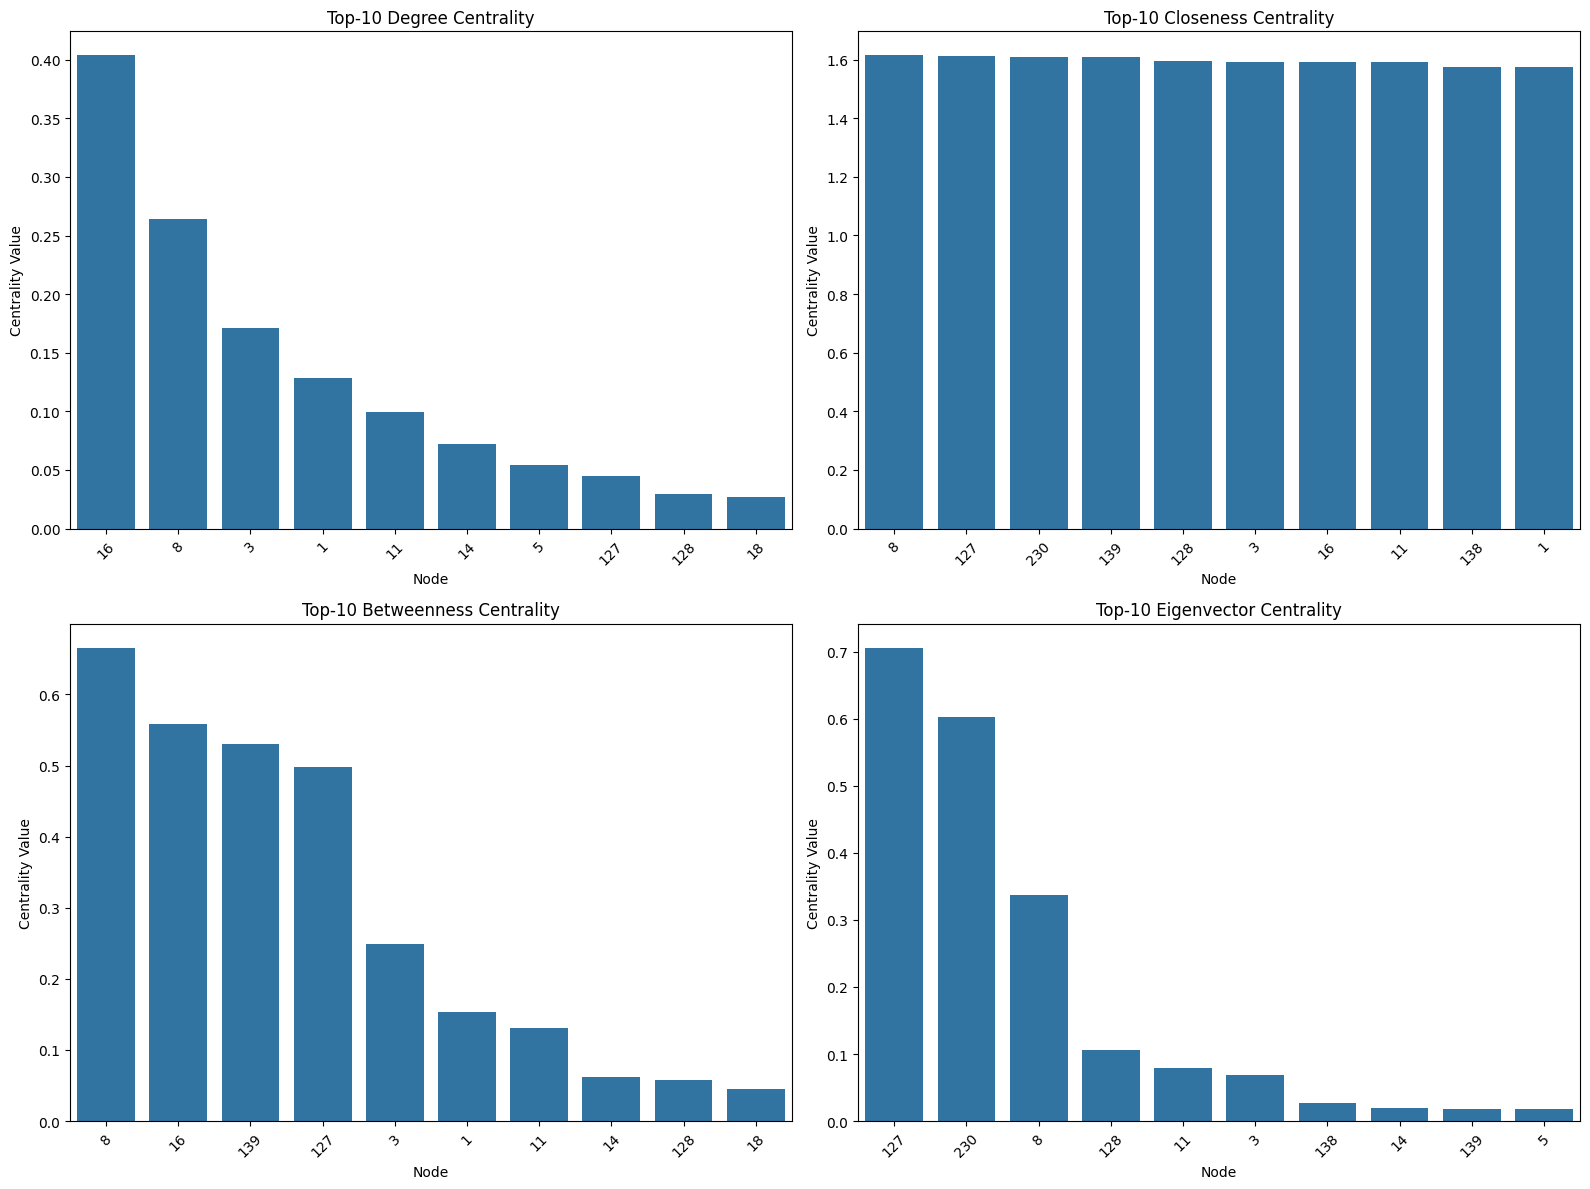

In [ ]:
TOP_K = 10

plt.figure(figsize=(16, 12))

# Degree Centrality (top-k)
plt.subplot(2, 2, 1)
sns.barplot(
    x="Node",
    y="Degree Centrality",
    data=degree_sorted.head(TOP_K)
)
plt.title("Top-10 Degree Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Closeness Centrality (top-k)
plt.subplot(2, 2, 2)
sns.barplot(
    x="Node",
    y="Closeness Centrality",
    data=closeness_sorted.head(TOP_K)
)
plt.title("Top-10 Closeness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Betweenness Centrality (top-k)
plt.subplot(2, 2, 3)
sns.barplot(
    x="Node",
    y="Betweenness Centrality",
    data=betweenness_sorted.head(TOP_K)
)
plt.title("Top-10 Betweenness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Eigenvector Centrality (top-k)
plt.subplot(2, 2, 4)
sns.barplot(
    x="Node",
    y="Eigenvector Centrality",
    data=eigenvector_sorted.head(TOP_K)
)
plt.title("Top-10 Eigenvector Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

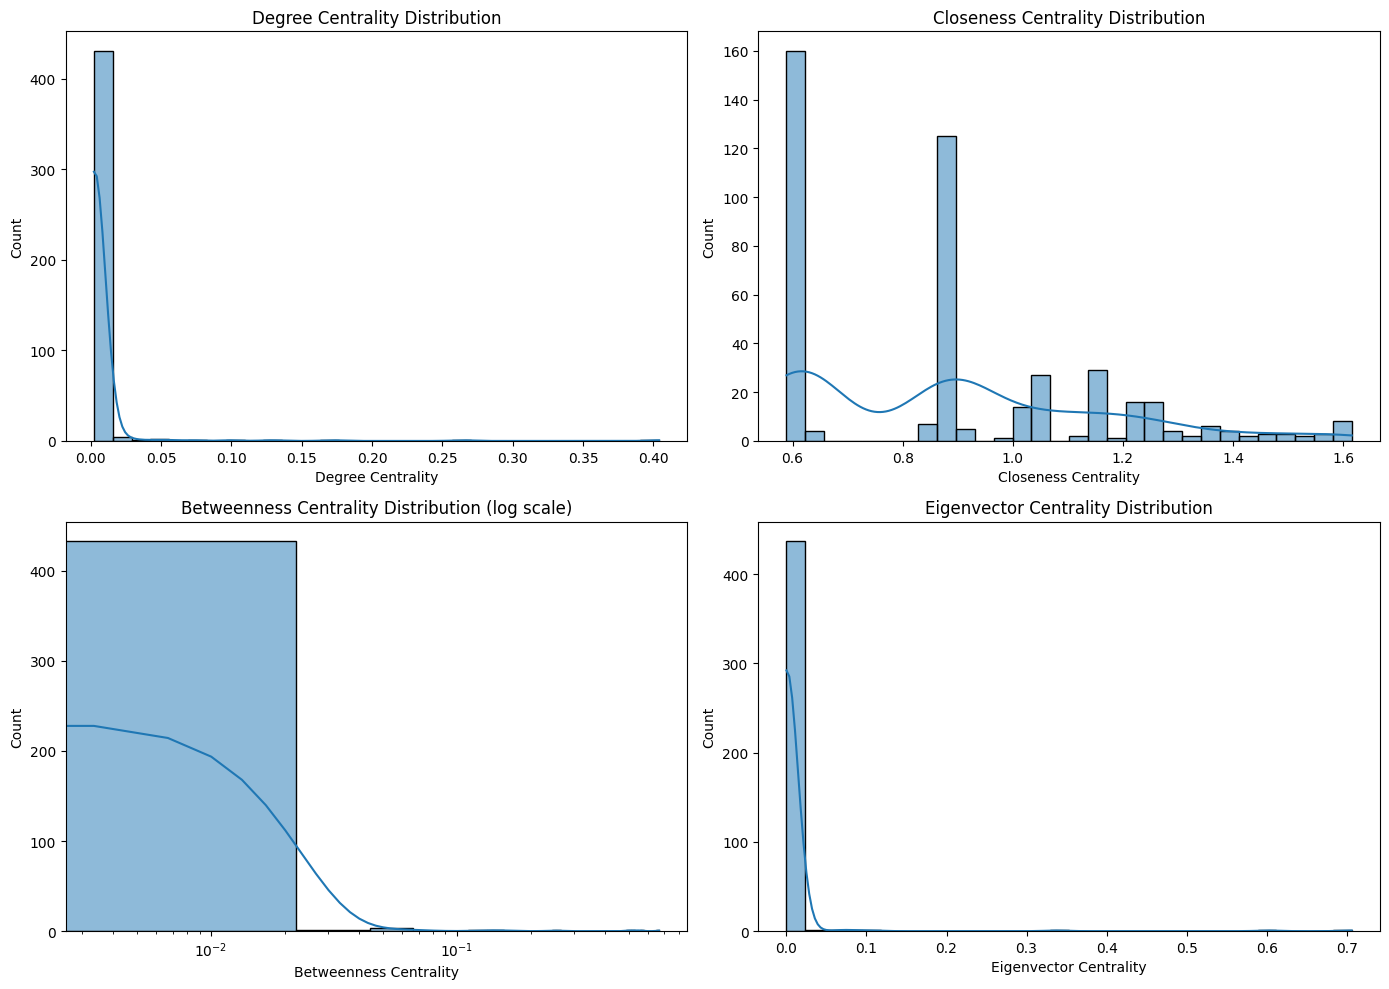

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(centrality_df["Degree Centrality"], kde=True, bins=30)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
sns.histplot(centrality_df["Closeness Centrality"], kde=True, bins=30)
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 3)
sns.histplot(centrality_df["Betweenness Centrality"], kde=True, bins=30)
plt.xscale("log")
plt.title("Betweenness Centrality Distribution (log scale)")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 4)
sns.histplot(centrality_df["Eigenvector Centrality"], kde=True, bins=30)
plt.title("Eigenvector Centrality Distribution")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


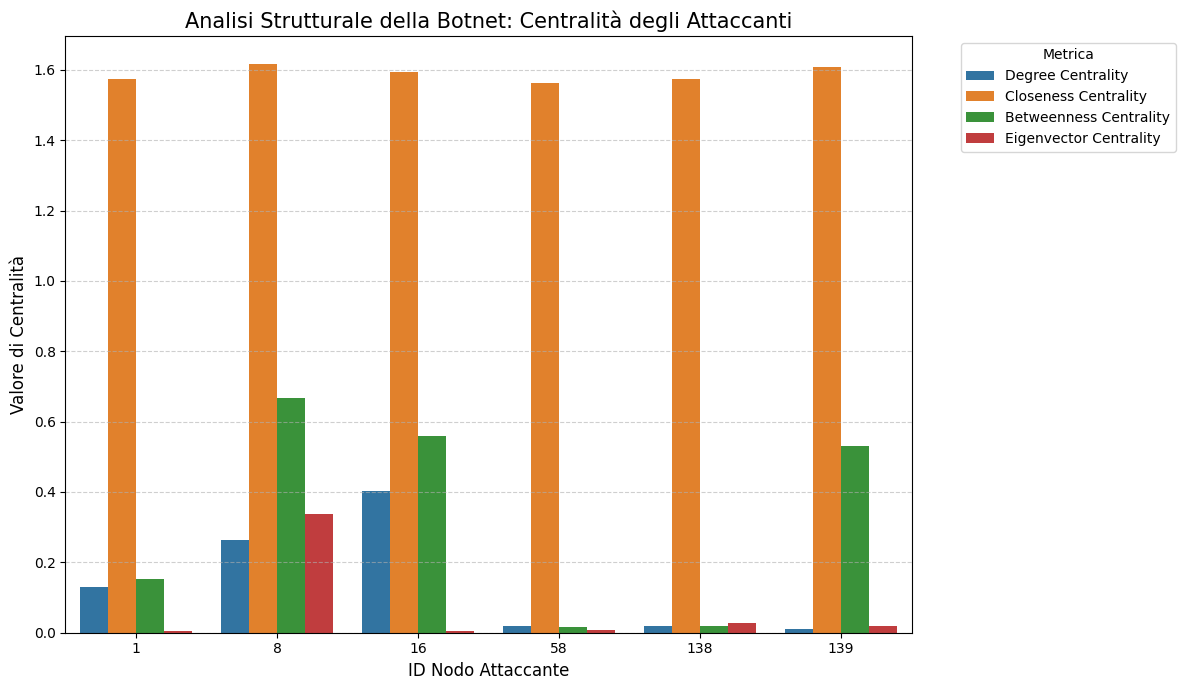

In [ ]:
# Lista degli attaccanti identificati
attaccanti_ids = [58, 139, 16, 8, 1, 138]
# Verifica che siano stringhe se DataFrame usa stringhe per i nodi
attaccanti_str = [str(node) for node in attaccanti_ids]

# Filtra il dataframe delle centralità solo per questi nodi
centrality_df_plot = centrality_df.copy()
centrality_df_plot["Node"] = centrality_df_plot["Node"].astype(str)

centrality_attackers = centrality_df_plot[centrality_df_plot["Node"].isin(attaccanti_str)]

# Trasformazione per il plot (Melt)
centrality_melted = pd.melt(
    centrality_attackers,
    id_vars="Node",
    value_vars=[
        "Degree Centrality", 
        "Closeness Centrality", 
        "Betweenness Centrality", 
        "Eigenvector Centrality"
    ],
    var_name="Centrality Metric",
    value_name="Value"
)

# Visualizzazione
plt.figure(figsize=(12, 7))
sns.barplot(
    data=centrality_melted,
    x="Node",
    y="Value",
    hue="Centrality Metric",
)

plt.title("Analisi Strutturale della Botnet: Centralità degli Attaccanti", fontsize=15)
plt.xlabel("ID Nodo Attaccante", fontsize=12)
plt.ylabel("Valore di Centralità", fontsize=12)
plt.legend(title="Metrica", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

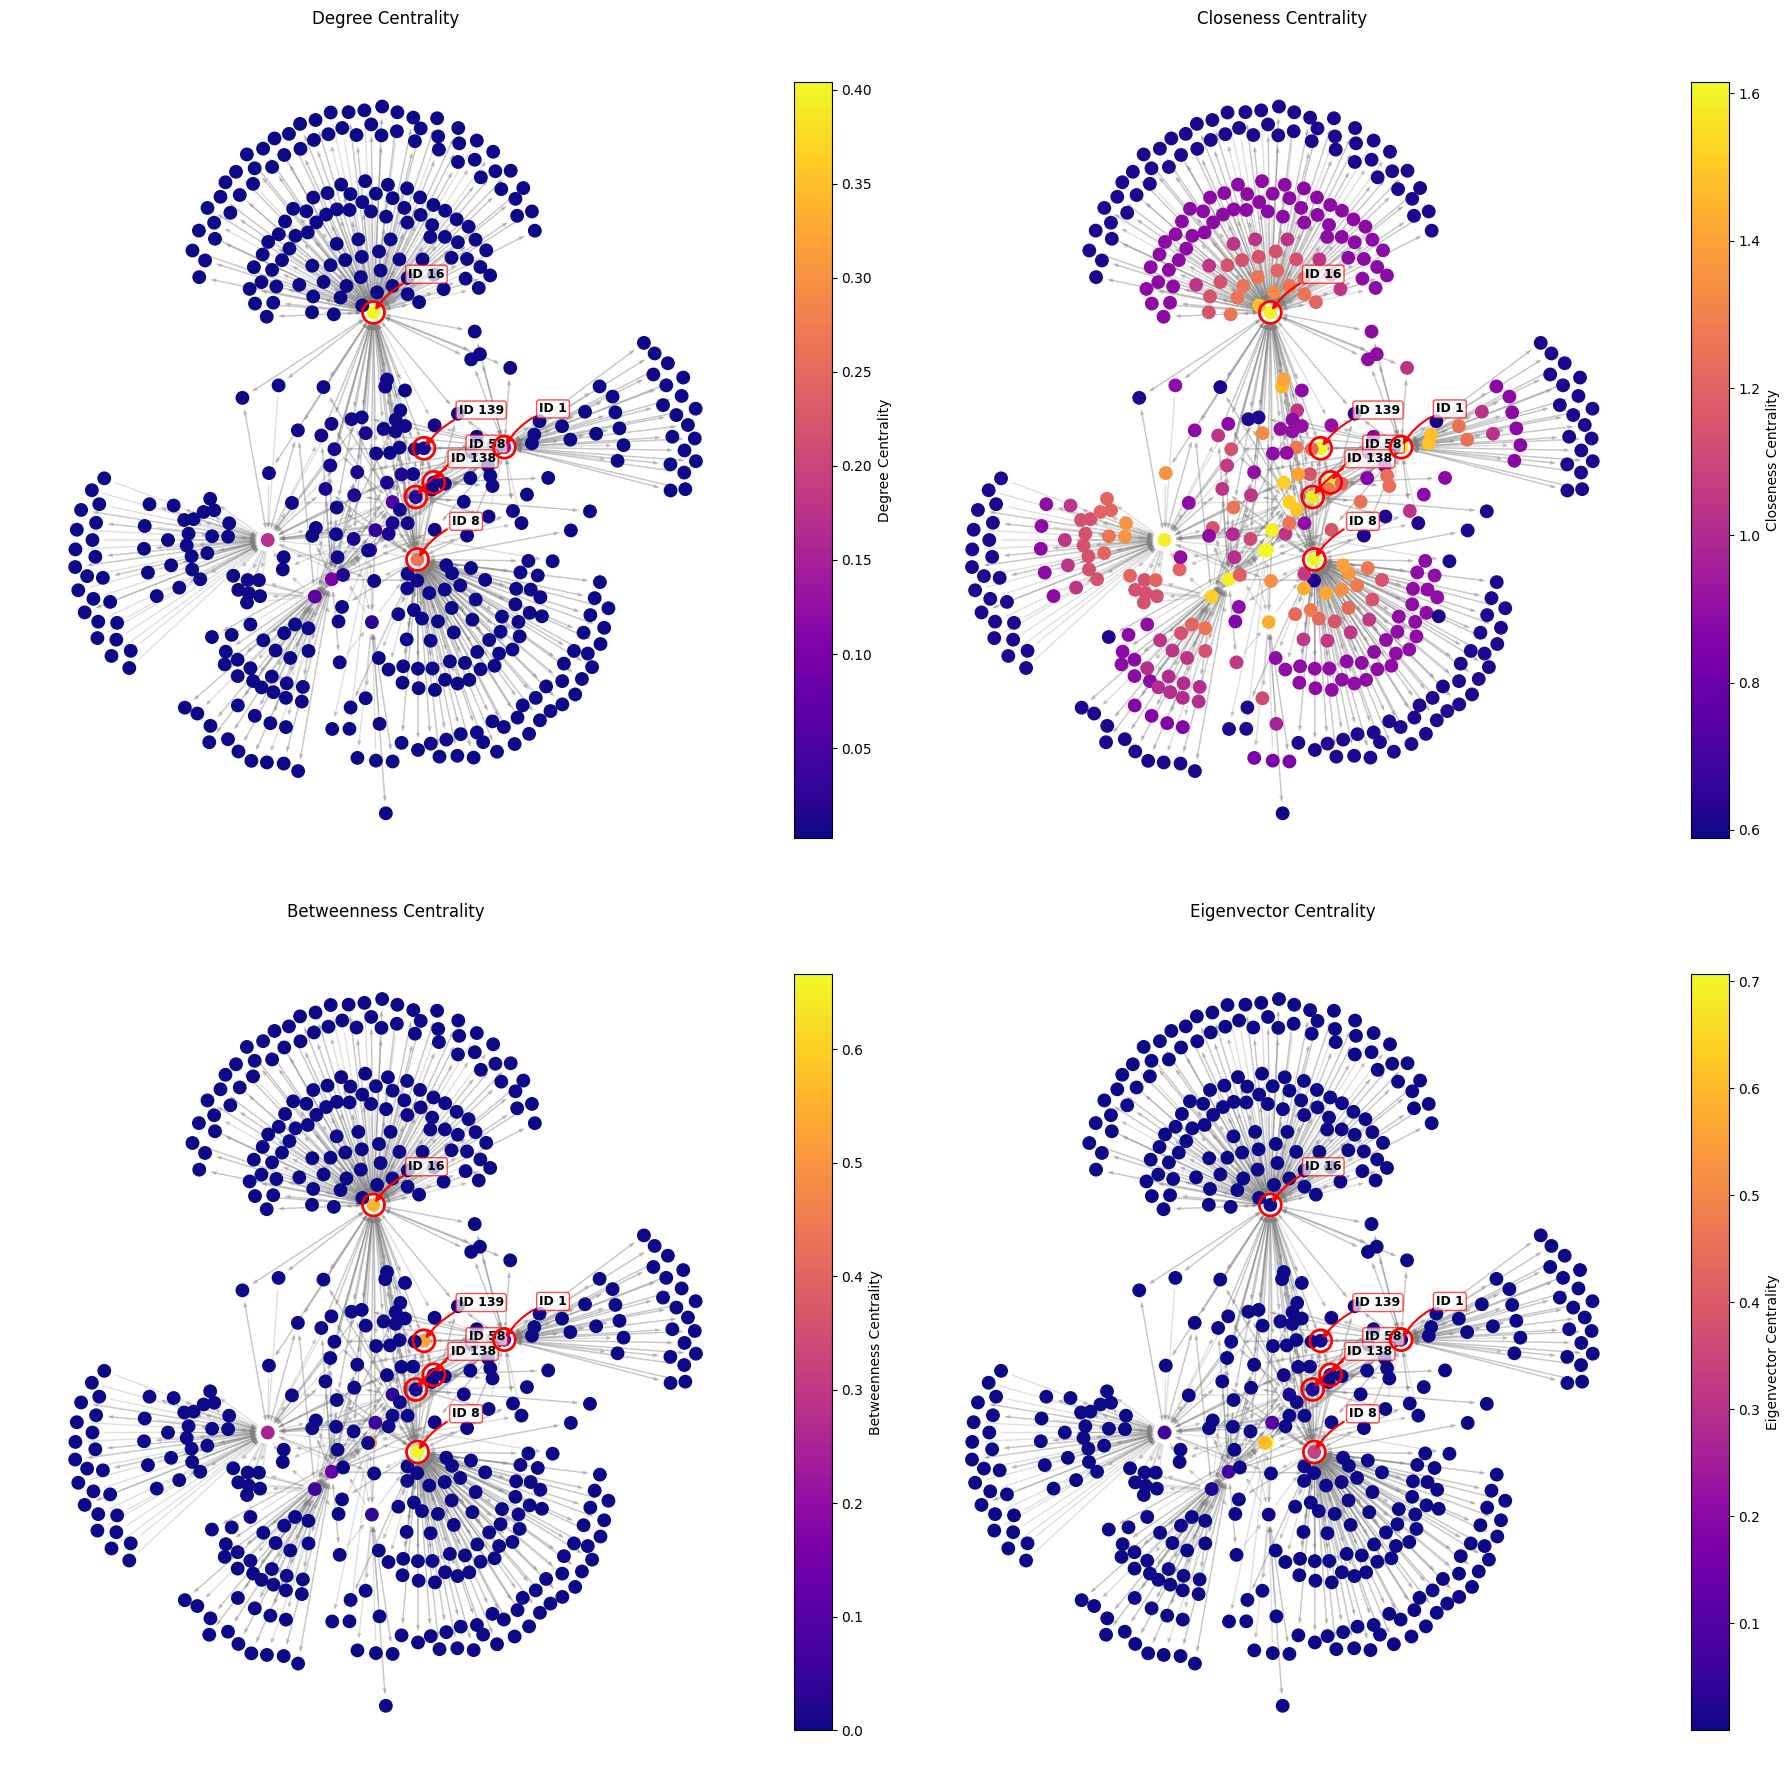

In [ ]:
# Viene effetuato il calcolo su H ovvero la componente debolmente connessa più grande definita prima
U = H.to_undirected()

# Posizione unica 
pos = nx.spring_layout(U, seed=42)

plt.figure(figsize=(18, 18))

node_size = 80          
with_labels = False     
edge_color = "gray"
edge_alpha = 0.25

# Funzione helper per un pannello
def draw_centrality_subplot(ax, graph, pos, cent_dict, title):
    values = [cent_dict.get(node, 0.0) for node in graph.nodes()]

    nx.draw_networkx_nodes(
        graph, pos,
        node_color=values,
        node_size=node_size,
        cmap="plasma",
        ax=ax
    )
    nx.draw_networkx_edges(
        graph, pos,
        edge_color=edge_color,
        alpha=edge_alpha,
        arrows=True,
        arrowsize=6,
        ax=ax
    )

    if with_labels:
        nx.draw_networkx_labels(graph, pos, font_size=6, ax=ax)

    sm = plt.cm.ScalarMappable(
        cmap="plasma",
        norm=plt.Normalize(vmin=min(values), vmax=max(values))
    )
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label=title)

    ax.set_title(title)
    ax.axis("off")

# 1) Degree
ax = plt.subplot(2, 2, 1)
draw_centrality_subplot(ax, H, pos, degree_centrality, "Degree Centrality")

# 2) Closeness
ax = plt.subplot(2, 2, 2)
draw_centrality_subplot(ax, H, pos, closeness_centrality, "Closeness Centrality")

# 3) Betweenness
ax = plt.subplot(2, 2, 3)
draw_centrality_subplot(ax, H, pos, betweenness_centrality, "Betweenness Centrality")

# 4) Eigenvector
ax = plt.subplot(2, 2, 4)
draw_centrality_subplot(ax, H, pos, eigenvector_centrality, "Eigenvector Centrality")

#
attaccanti_ids = [58, 139, 16, 8, 1, 138]

for target_node in attaccanti_ids:
    if target_node in pos:
        x, y = pos[target_node]
        
        # Per ogni subplot
        for i, ax in enumerate(plt.gcf().axes[::2]): 
            ax.annotate(
                f"ID {target_node}",
                xy=(x, y), 
                xytext=(25, 25), # Distanza dell'etichetta dal nodo
                textcoords='offset points',
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc3,rad=.2",
                    color='red', 
                    lw=1.5
                ),
                fontsize=9, 
                fontweight='bold',
                color='black',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.7)
            )

            # Disegna un cerchio rosso intorno ai nodi attaccanti per trovarli subito
            ax.scatter(x, y, s=250, facecolors='none', edgecolors='red', linewidths=2, zorder=5)

plt.tight_layout()
plt.show()


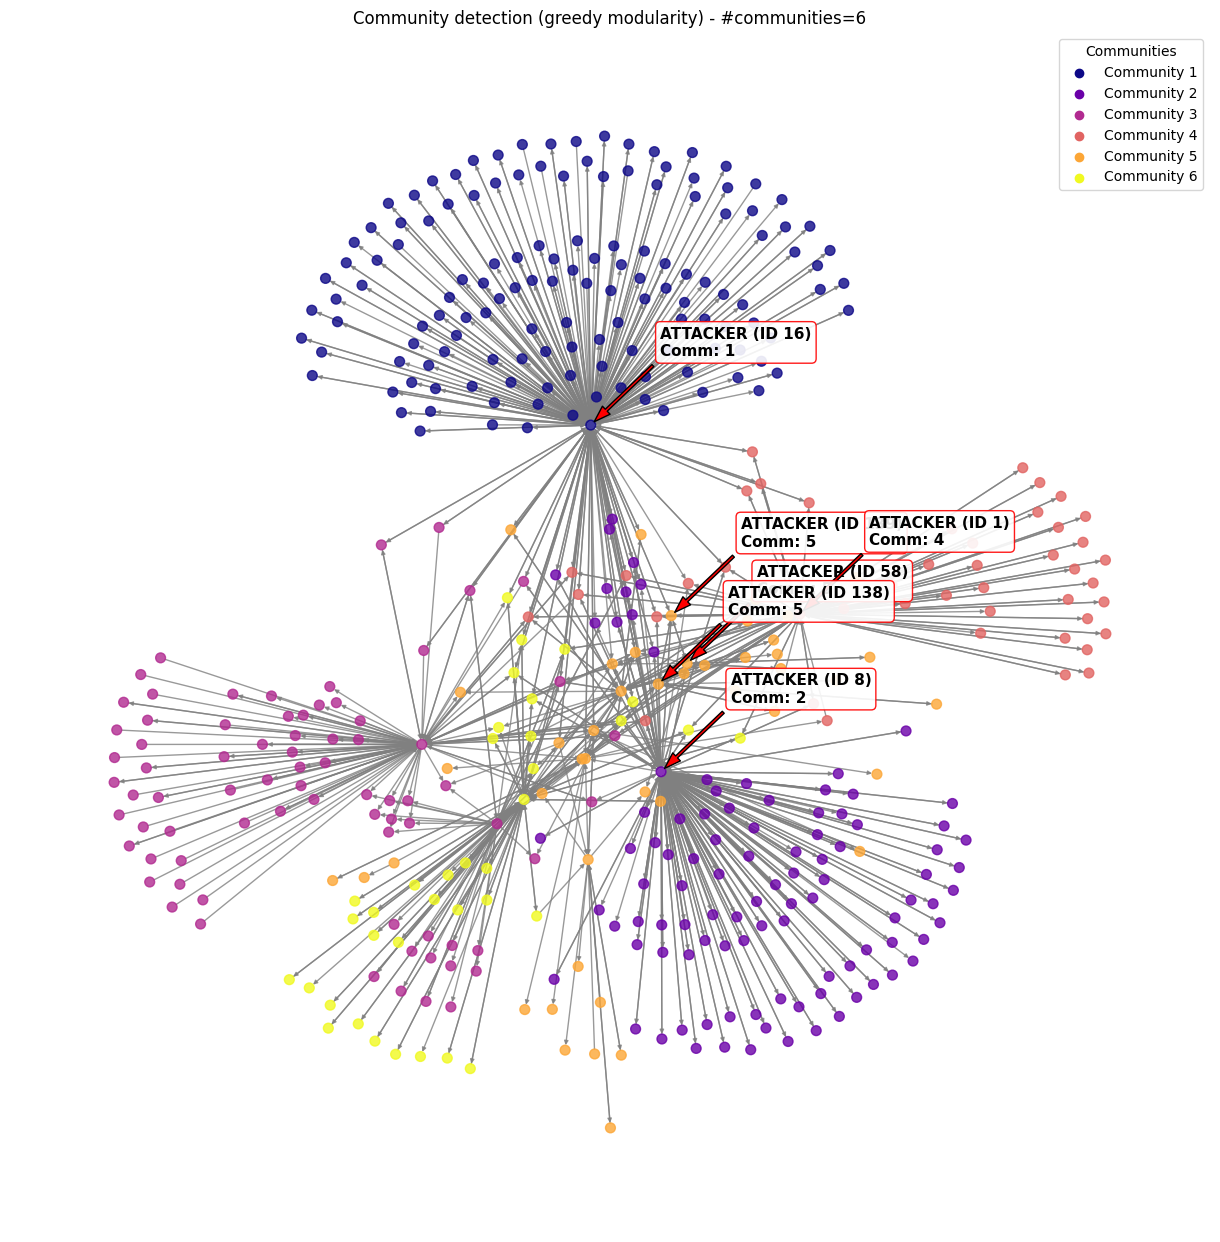

In [ ]:
pos = nx.spring_layout(U, seed=42)

# Community detection
communities = list(greedy_modularity_communities(U))

community_colors = plt.cm.plasma(np.linspace(0, 1, len(communities)))
node_color = {}

for i, community in enumerate(communities):
    for node in community:
        node_color[node] = community_colors[i]

colors = [node_color.get(node, (0.7, 0.7, 0.7, 1.0)) for node in U.nodes]

# Plot
plt.figure(figsize=(12, 12))
nx.draw(
    H, pos,
    node_color=colors,
    with_labels=False,      
    node_size=50,
    edge_color="gray",
    alpha=0.8,
    arrows=True,
    arrowsize=6
)

# Legenda
if len(communities) <= MAX_LEGEND:
    for i in range(len(communities)):
        plt.scatter([], [], color=community_colors[i], label=f'Community {i+1}')
    plt.legend(title="Communities", loc="best")

plt.title(f"Community detection (greedy modularity) - #communities={len(communities)}")
plt.axis("off")

attaccanti_ids = [58, 139, 16, 8, 1, 138]

for target_node in attaccanti_ids:
    if target_node in pos:
        plt.annotate(
        f"ATTACKER (ID {target_node})\nComm: {next(i+1 for i, c in enumerate(communities) if target_node in c)}",
        xy=pos[target_node],
        xytext=(50, 50),
        textcoords='offset points',
        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
        fontsize=11,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9)
    )
    
    
plt.show()

ANALISI DELLE STRUTTURE PER LE BOTNET

In [ ]:
# Preparazione del grafo non diretto
U = H.to_undirected()
# Lista degli attaccanti identificati per la Botnet
attaccanti_ids = [58, 139, 16, 8, 1, 138] 

# Ricerca di tutte le clique nel grafo
cliques = list(nx.find_cliques(U))

# Analisi Generale
clique_count = len(cliques)
max_clique_size = max(len(c) for c in cliques)
largest_cliques = [c for c in cliques if len(c) == max_clique_size]

print(f"ANALISI GENERALE DELLE CLIQUE")
print(f"Numero totale di clique nella rete: {clique_count}")
print(f"Dimensione massima clique (Benign): {max_clique_size}")
print(f"Esempio di clique principale: {largest_cliques[0] if largest_cliques else 'N/A'}")

print(f"\nANALISI MIRATA SULLA BOTNET")

# Analisi iterativa per ogni membro della botnet
for attacker_id in attaccanti_ids:
    if attacker_id in U.nodes():
        # Clique che coinvolgono lo specifico bot
        attacker_cliques = [c for c in cliques if attacker_id in c]
        attacker_max_clique = max(len(c) for c in attacker_cliques) if attacker_cliques else 0
        
        # Clustering Coefficient (Misura quanto i vicini dell'attaccante sono connessi tra loro)
        cc_attacker = nx.clustering(U, attacker_id)
        
        # Verifica se è nella clique principale
        is_in_main = any(attacker_id in c for c in largest_cliques)

        print(f"Nodo {attacker_id:3}: Numero Clique: {len(attacker_cliques):2} | Dimensione massima Clique: {attacker_max_clique:2} | CC: {cc_attacker:.6f} | E' presente nella Clique di dimensione massima ?: {'SÌ' if is_in_main else 'NO'}")
    else:
        print(f"Nodo {attacker_id:3}: Non presente nel grafo H.")

# Analisi di Gruppo
botnet_cliques = [c for c in cliques if any(aid in c for aid in attaccanti_ids)]
# Filtra le clique che hanno almeno 2 attaccanti insieme
coordinated_cliques = [c for c in botnet_cliques if sum(1 for node in c if node in attaccanti_ids) >= 2]

print(f"\nCOORDINAZIONE MALEVOLA")
print(f"Numero di clique con almeno 2 attaccanti: {len(coordinated_cliques)}")
if coordinated_cliques:
    print(f"Esempio di clique coordinata: {coordinated_cliques[0]}")

ANALISI GENERALE DELLE CLIQUE
Numero totale di clique nella rete: 559
Dimensione massima clique (Benign): 3
Esempio di clique principale: [1, 127, 128]

ANALISI MIRATA SULLA BOTNET
Nodo  58: Numero Clique:  9 | Dimensione massima Clique:  2 | CC: 0.000000 | E' presente nella Clique di dimensione massima ?: NO
Nodo 139: Numero Clique:  5 | Dimensione massima Clique:  2 | CC: 0.000000 | E' presente nella Clique di dimensione massima ?: NO
Nodo  16: Numero Clique: 178 | Dimensione massima Clique:  3 | CC: 0.000063 | E' presente nella Clique di dimensione massima ?: SÌ
Nodo   8: Numero Clique: 116 | Dimensione massima Clique:  3 | CC: 0.000147 | E' presente nella Clique di dimensione massima ?: SÌ
Nodo   1: Numero Clique: 56 | Dimensione massima Clique:  3 | CC: 0.001880 | E' presente nella Clique di dimensione massima ?: SÌ
Nodo 138: Numero Clique:  8 | Dimensione massima Clique:  3 | CC: 0.055556 | E' presente nella Clique di dimensione massima ?: SÌ

COORDINAZIONE MALEVOLA
Numero di cli

In [ ]:
# Calcolo globale dei triangoli
triangles_dict = nx.triangles(U)
total_triangles = sum(triangles_dict.values()) // 3

# Calcolo totale delle triadi aperte nella rete
total_triads_all = sum(d * (d - 1) // 2 for n, d in U.degree())
total_open_triads = total_triads_all - (total_triangles * 3)

print(f"ANALISI DELLE TRIADI: RETE GENERALE")
print(f"Triadi Chiuse (Triangoli) totali: {total_triangles}")
print(f"Triadi Aperte (Wedges) totali:    {total_open_triads}")

# Focus sul gruppo Botnet
attaccanti_ids = [58, 139, 16, 8, 1, 138]

print(f"\nANALISI DETTAGLIATA ATTACCANTI (BOTNET)")
for attacker_id in attaccanti_ids:
    if attacker_id in U.nodes():
        d_att = U.degree(attacker_id)
        # Triadi totali in cui il nodo è il vertice centrale
        attacker_total_triads = d_att * (d_att - 1) // 2
        attacker_closed_triads = triangles_dict.get(attacker_id, 0)
        attacker_open_triads = attacker_total_triads - attacker_closed_triads
        
        ratio = (attacker_closed_triads / attacker_total_triads * 100) if attacker_total_triads > 0 else 0
        
        print(f"ID {attacker_id:3} | Triadi Tot: {attacker_total_triads:4} | Chiuse: {attacker_closed_triads:2} | Aperte: {attacker_open_triads:4} | Chiusura: {ratio:.2f}%")
    else:
        print(f"ID {attacker_id:3} | Nodo non presente nel grafo.")


--- ANALISI DELLE TRIADI: RETE GENERALE ---
Triadi Chiuse (Triangoli) totali: 19
Triadi Aperte (Wedges) totali:    29444

--- ANALISI DETTAGLIATA ATTACCANTI (BOTNET) ---
ID  58 | Triadi Tot:   36 | Chiuse:  0 | Aperte:   36 | Chiusura: 0.00%
ID 139 | Triadi Tot:   10 | Chiuse:  0 | Aperte:   10 | Chiusura: 0.00%
ID  16 | Triadi Tot: 15931 | Chiuse:  1 | Aperte: 15930 | Chiusura: 0.01%
ID   8 | Triadi Tot: 6786 | Chiuse:  1 | Aperte: 6785 | Chiusura: 0.01%
ID   1 | Triadi Tot: 1596 | Chiuse:  3 | Aperte: 1593 | Chiusura: 0.19%
ID 138 | Triadi Tot:   36 | Chiuse:  2 | Aperte:   34 | Chiusura: 5.56%


In [ ]:
# Calcolo della struttura k-core sulla rete U (non diretta)
k_core_dict = {}
# Calcolo del core number per ogni nodo
core_numbers = nx.core_number(U)
max_k = max(core_numbers.values())

# Crea un sommario della distribuzione dei k-core
import collections
k_distribution = collections.Counter(core_numbers.values())
k_core_summary = sorted(k_distribution.items())

print("ANALISI K-CORE GENERALE")
print("Distribuzione k-core (k : numero nodi che hanno quel k massimo):")
for k, count in k_core_summary:
    print(f"  k = {k}: {count} nodi")

print(f"\nMax k della rete: {max_k}")
largest_k_core_nodes = [node for node, k in core_numbers.items() if k == max_k]
print(f"Nodi nel core massimo (primi 10): {largest_k_core_nodes[:10]}")

# Analisi specifica sul gruppo Botnet
attaccanti_ids = [58, 139, 16, 8, 1, 138]

print(f"\nPOSIZIONAMENTO ATTACCANTI NEL CORE")
for attacker_id in attaccanti_ids:
    if attacker_id in core_numbers:
        k_attacker = core_numbers[attacker_id]
        
        status = ""
        if k_attacker == max_k:
            status = "CORE MASSIMO (Massima integrazione)"
        elif k_attacker > 1:
            status = "CORE INTERMEDIO"
        else:
            status = "PERIFERIA (Struttura a stella/isolata)"
            
        print(f"Nodo {attacker_id:3} | k-core: {k_attacker:2} | Posizione: {status}")
    else:
        print(f"Nodo {attacker_id:3} | Non presente nel grafo.")

--- ANALISI K-CORE GENERALE ---
Distribuzione k-core (k : numero nodi che hanno quel k massimo):
  k = 1: 363 nodi
  k = 2: 40 nodi
  k = 3: 18 nodi
  k = 4: 23 nodi

Max k della rete: 4
Nodi nel core massimo (primi 10): [1, 3, 5, 8, 11, 14, 16, 18, 58, 63]

--- POSIZIONAMENTO ATTACCANTI NEL CORE ---
Nodo  58 | k-core:  4 | Posizione: CORE MASSIMO (Massima integrazione)
Nodo 139 | k-core:  4 | Posizione: CORE MASSIMO (Massima integrazione)
Nodo  16 | k-core:  4 | Posizione: CORE MASSIMO (Massima integrazione)
Nodo   8 | k-core:  4 | Posizione: CORE MASSIMO (Massima integrazione)
Nodo   1 | k-core:  4 | Posizione: CORE MASSIMO (Massima integrazione)
Nodo 138 | k-core:  3 | Posizione: CORE INTERMEDIO


In [ ]:
# Lista degli attaccanti identificati
attaccanti_ids = [58, 139, 16, 8, 1, 138]

print(f"--- ANALISI EGO-NETWORKS DEGLI ATTACCANTI (BOTNET) ---")

for node_id in attaccanti_ids:
    if node_id in U:
        # Generazione Ego-network del singolo attaccante
        ego_net = nx.ego_graph(U, node_id)
        
        n_nodi = ego_net.number_of_nodes()
        n_archi = ego_net.number_of_edges()
        
        # Calcola la densità della Ego-network
        # Una densità molto bassa (vicina a 0) indica una struttura a stella (Botnet)
        # Una densità alta indica che i vicini del nodo formano una comunità (Benign)
        densita = nx.density(ego_net)
        
        print(f"\nEgo-network NODO {node_id}:")
        print(f"  - Vicini diretti (Size): {n_nodi - 1}") # Sottraiamo il nodo stesso
        print(f"  - Connessioni totali nell'intorno: {n_archi}")
        print(f"  - Densità locale: {densita:.4f}")
        
        # Interpretazione della struttura
        if n_nodi > 5 and densita < 0.1:
            print(f"  > Diagnosi: Topologia a STELLA rilevata. Comportamento tipico da Master/C&C.")
        elif n_nodi <= 2:
            print(f"  > Diagnosi: Nodo periferico (Zombie).")
        else:
            print(f"  > Diagnosi: Struttura mista o traffico di servizio.")
    else:
        print(f"\nNodo {node_id}: Non presente nel grafo attuale.")



--- ANALISI EGO-NETWORKS DEGLI ATTACCANTI (BOTNET) ---

Ego-network NODO 58:
  - Vicini diretti (Size): 9
  - Connessioni totali nell'intorno: 9
  - Densità locale: 0.2000
  > Diagnosi: Struttura mista o traffico di servizio.

Ego-network NODO 139:
  - Vicini diretti (Size): 5
  - Connessioni totali nell'intorno: 5
  - Densità locale: 0.3333
  > Diagnosi: Struttura mista o traffico di servizio.

Ego-network NODO 16:
  - Vicini diretti (Size): 179
  - Connessioni totali nell'intorno: 180
  - Densità locale: 0.0112
  > Diagnosi: Topologia a STELLA rilevata. Comportamento tipico da Master/C&C.

Ego-network NODO 8:
  - Vicini diretti (Size): 117
  - Connessioni totali nell'intorno: 118
  - Densità locale: 0.0171
  > Diagnosi: Topologia a STELLA rilevata. Comportamento tipico da Master/C&C.

Ego-network NODO 1:
  - Vicini diretti (Size): 57
  - Connessioni totali nell'intorno: 60
  - Densità locale: 0.0363
  > Diagnosi: Topologia a STELLA rilevata. Comportamento tipico da Master/C&C.

Ego-n

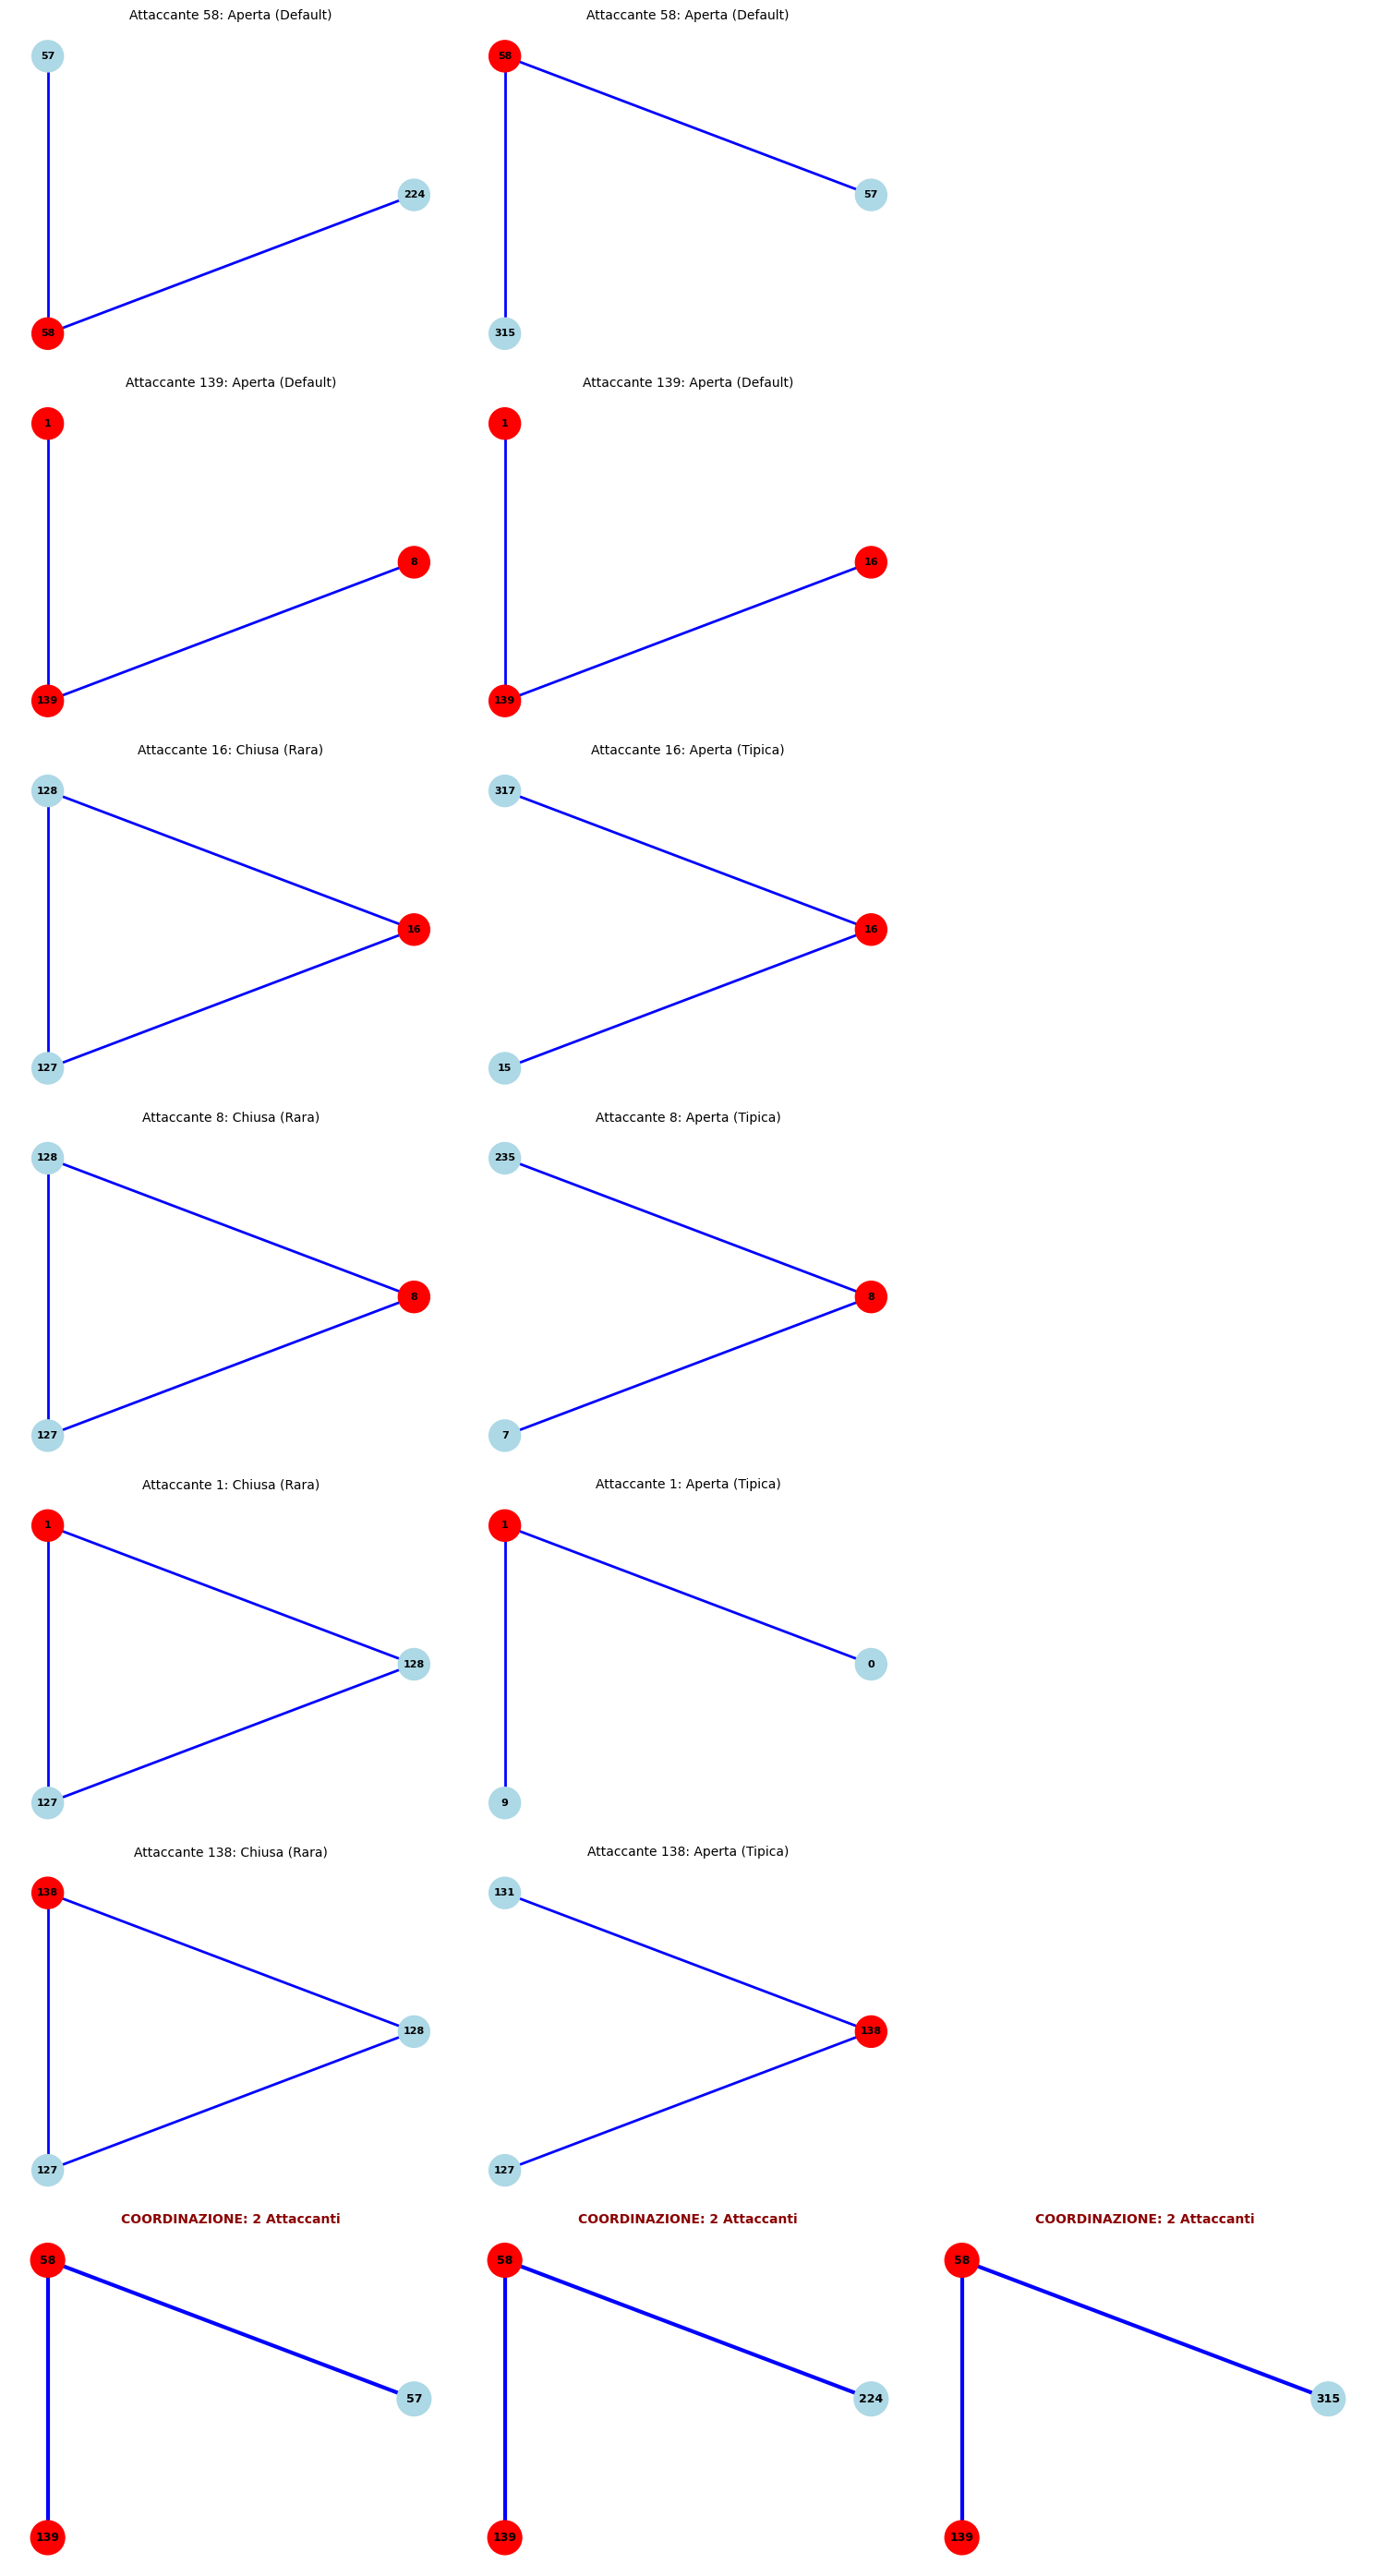

In [ ]:
# Lista degli attaccanti identificati
attaccanti_ids = [58, 139, 16, 8, 1, 138]
set_attaccanti = set(attaccanti_ids)

# Identificazione Triadi di Coordinazione (almeno 2 attaccanti coinvolti)
triadi_coordinazione = []
nodi_visitati = set()

# Cerca nel grafo globale triadi con >= 2 attaccanti
for u in attaccanti_ids:
    if u not in U: continue
    vicini = list(U.neighbors(u))
    for idx, v in enumerate(vicini):
        for x in vicini[idx + 1:]:
            trio = sorted([u, v, x])
            trio_tuple = tuple(trio)
            if trio_tuple not in nodi_visitati:
                # Conta quanti nodi nel trio sono nella lista attaccanti
                count_att = sum(1 for n in trio if n in set_attaccanti)
                if count_att >= 2:
                    triadi_coordinazione.append(trio)
                    nodi_visitati.add(trio_tuple)

# Preparazione della figura
# Righe per gli attaccanti singoli + 1 riga per la coordinazione (max 3 triadi)
n_coordinated = min(3, len(triadi_coordinazione))
total_rows = len(attaccanti_ids) + (1 if n_coordinated > 0 else 0)
fig = plt.figure(figsize=(15, 4 * total_rows))

# Triadi per ogni attaccante
for i, u in enumerate(attaccanti_ids):
    if u not in U: continue
    
    vicini = list(U.neighbors(u))
    triadi_chiuse = []
    triadi_aperte = []
    
    for idx, v in enumerate(vicini):
        for x in vicini[idx + 1:]:
            trio = [u, v, x]
            if U.has_edge(v, x): triadi_chiuse.append(trio)
            else: triadi_aperte.append(trio)
    
    to_display = []
    labels = []
    if len(triadi_chiuse) >= 1:
        to_display.append(triadi_chiuse[0]); labels.append("Chiusa (Rara)")
        if len(triadi_aperte) >= 1: to_display.append(triadi_aperte[0]); labels.append("Aperta (Tipica)")
        elif len(triadi_chiuse) > 1: to_display.append(triadi_chiuse[1]); labels.append("Chiusa")
    else:
        for j in range(min(2, len(triadi_aperte))):
            to_display.append(triadi_aperte[j]); labels.append("Aperta (Default)")

    for j, trio in enumerate(to_display):
        ax = plt.subplot(total_rows, 3, i*3 + j + 1) 
        subU = U.subgraph(trio)
        pos = nx.circular_layout(subU)
        node_colors = ["red" if n in set_attaccanti else "lightblue" for n in subU.nodes()]
    
        nx.draw(subU, pos, ax=ax, with_labels=True, node_size=600, node_color=node_colors, 
                edge_color="blue", width=2, font_size=8, font_weight="bold")
        ax.set_title(f"Attaccante {u}: {labels[j]}", fontsize=10)

# Triadi di coordinazione 
if n_coordinated > 0:
    row_offset = len(attaccanti_ids) * 3
    for j in range(n_coordinated):
        ax = plt.subplot(total_rows, 3, row_offset + j + 1)
        trio = triadi_coordinazione[j]
        subU = U.subgraph(trio)
        pos = nx.circular_layout(subU)
        
        node_colors = ["red" if n in set_attaccanti else "lightblue" for n in subU.nodes()]
        nx.draw(subU, pos, ax=ax, with_labels=True, node_size=700, node_color=node_colors, 
                edge_color="blue", width=3, font_size=9, font_weight="bold")
        ax.set_title(f"COORDINAZIONE: {sum(1 for n in trio if n in set_attaccanti)} Attaccanti", 
                     fontsize=10, fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

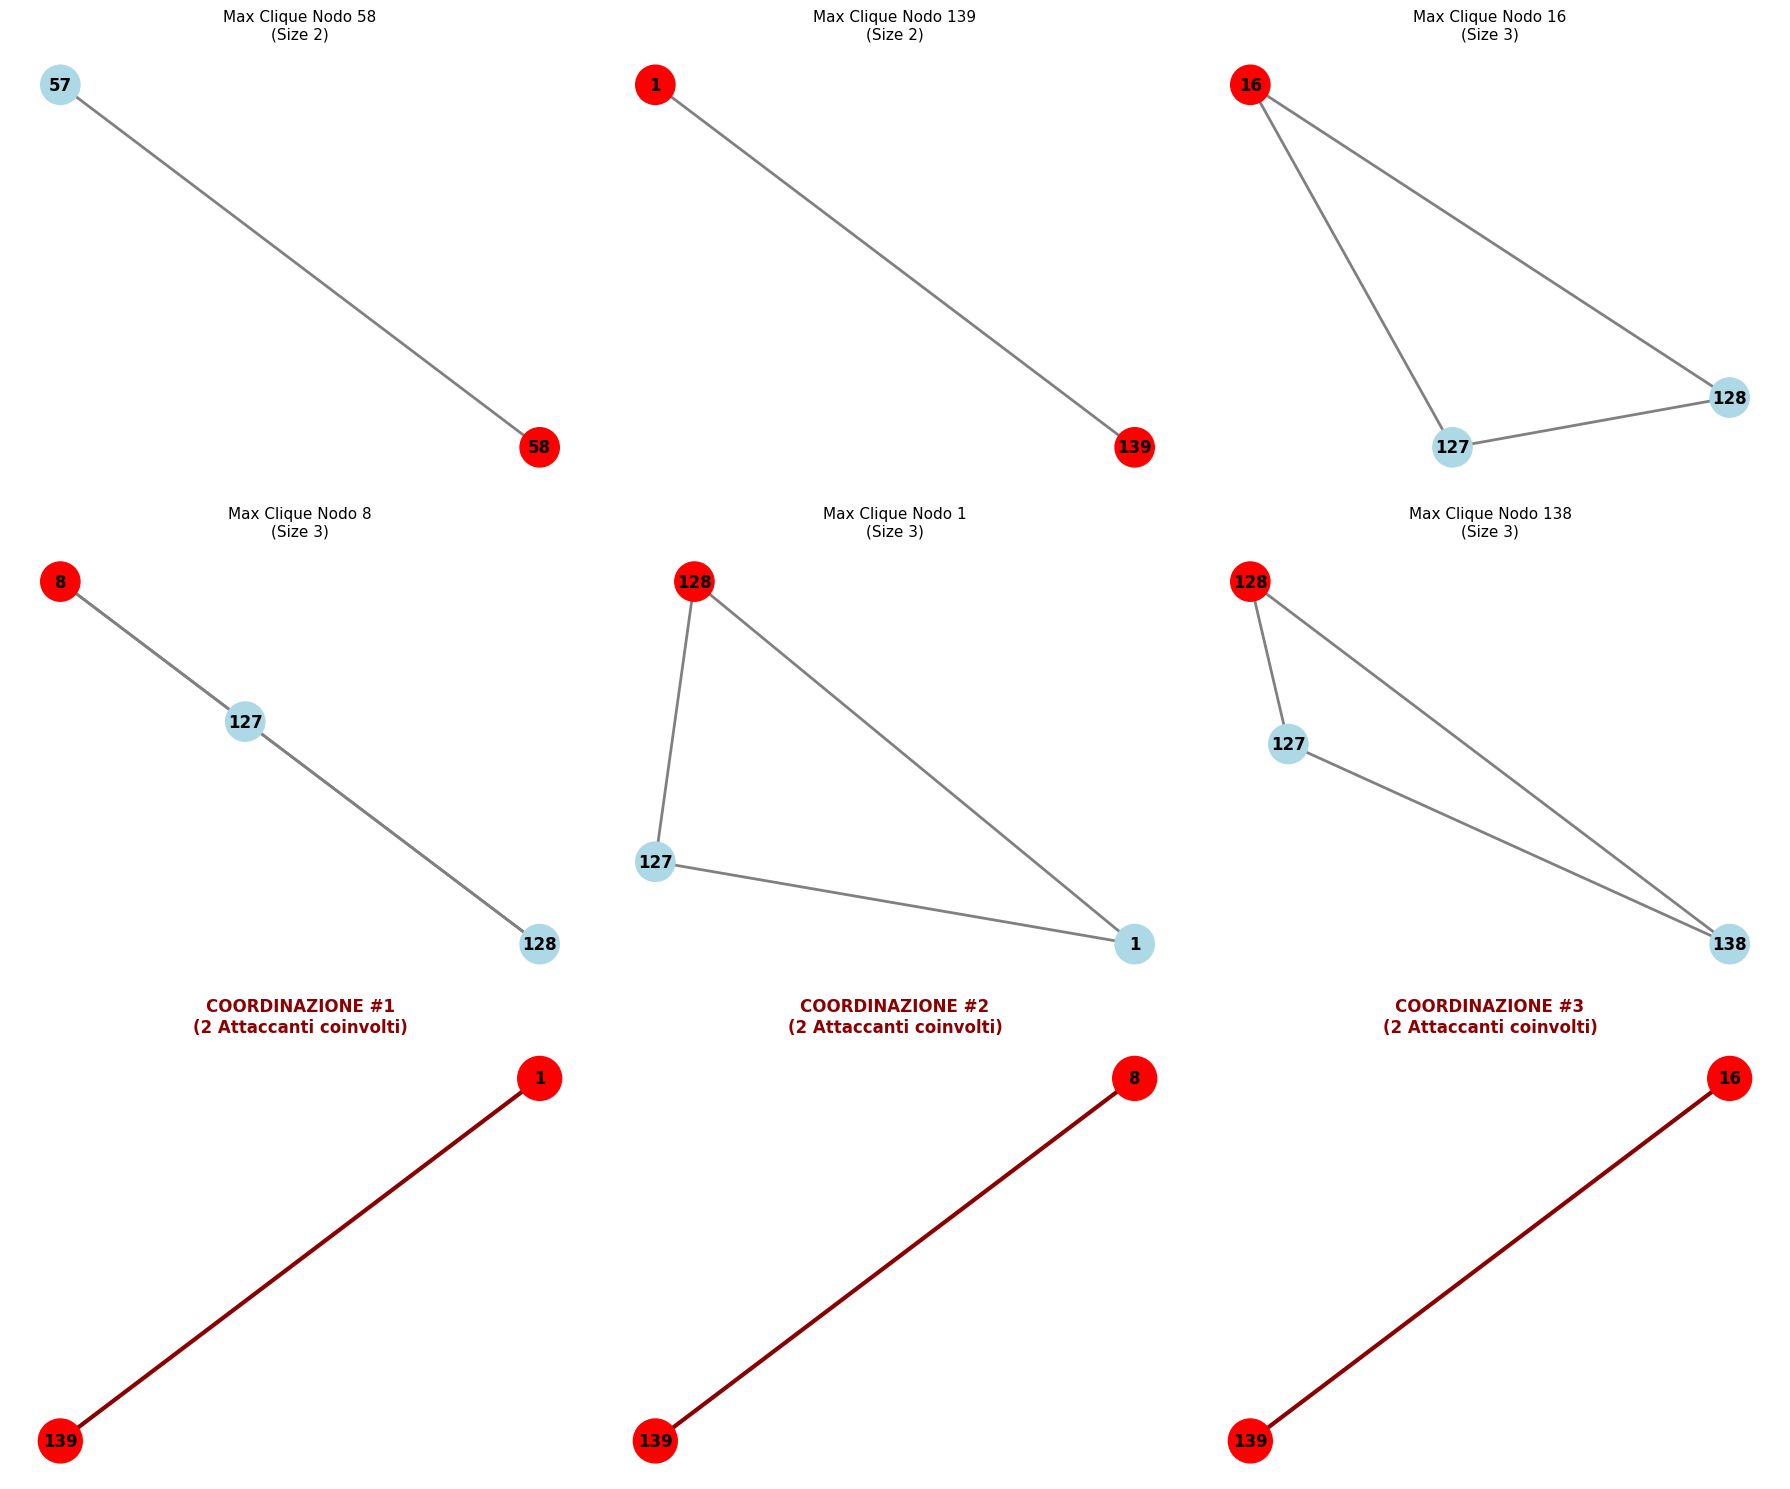

In [ ]:
# Configurazione Liste
attaccanti_ids = [58, 139, 16, 8, 1, 138]
set_attaccanti = set(attaccanti_ids)

# Recupero Clique per ogni Attaccante (Dimensione Massima)
cliques = list(nx.find_cliques(U))
individual_max_cliques = []

for aid in attaccanti_ids:
    if aid in U:
        # Trova la clique più grande a cui partecipa il nodo aid
        a_cliques = [c for c in cliques if aid in c]
        if a_cliques:
            max_c = max(a_cliques, key=len)
            individual_max_cliques.append((aid, max_c))

# Selezione Clique di Coordinazione (Top 3 per numero di attaccanti)
coordinated_cliques = [c for c in cliques if sum(1 for n in c if n in set_attaccanti) >= 2]
# Ordina per numero di attaccanti presenti nella clique (discendente) e ne prende 3
top_coordinated = sorted(coordinated_cliques, 
                         key=lambda c: sum(1 for n in c if n in set_attaccanti), 
                         reverse=True)[:3]

# Preparazione Plot
# Crea due sezioni: una per i bot individuali e una per la coordinazione
total_plots = len(individual_max_cliques) + len(top_coordinated)
cols = 3
rows = (total_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

# DISEGNO CLIQUE INDIVIDUALI
for i, (aid, nodes) in enumerate(individual_max_cliques):
    C = U.subgraph(nodes)
    pos = nx.spring_layout(C, seed=42)
    
    node_colors = ["red" if n in set_attaccanti else "lightblue" for n in nodes]
    
    nx.draw(C, pos, ax=axes[i], with_labels=True, node_size=800,
            node_color=node_colors, edge_color="gray", font_weight="bold", width=2)
    
    axes[i].set_title(f"Max Clique Nodo {aid}\n(Size {len(nodes)})", fontsize=11)
    axes[i].axis("off")

# DISEGNO CLIQUE COORDINATE (Top 3)
start_idx = len(individual_max_cliques)
for j, nodes in enumerate(top_coordinated):
    idx = start_idx + j
    C = U.subgraph(nodes)
    pos = nx.circular_layout(C) 
    
    node_colors = ["red" if n in set_attaccanti else "lightblue" for n in nodes]
    num_att = sum(1 for n in nodes if n in set_attaccanti)
    
    nx.draw(C, pos, ax=axes[idx], with_labels=True, node_size=1000,
            node_color=node_colors, edge_color="darkred", font_weight="bold", width=3)
    
    axes[idx].set_title(f"COORDINAZIONE #{j+1}\n({num_att} Attaccanti coinvolti)", 
                        fontsize=12, fontweight='bold', color='darkred')
    axes[idx].axis("off")

# Rimuovi assi vuoti
for k in range(total_plots, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

Core number massimo della rete: 4
Attaccanti nel core massimo: [58, 139, 16, 8, 1]


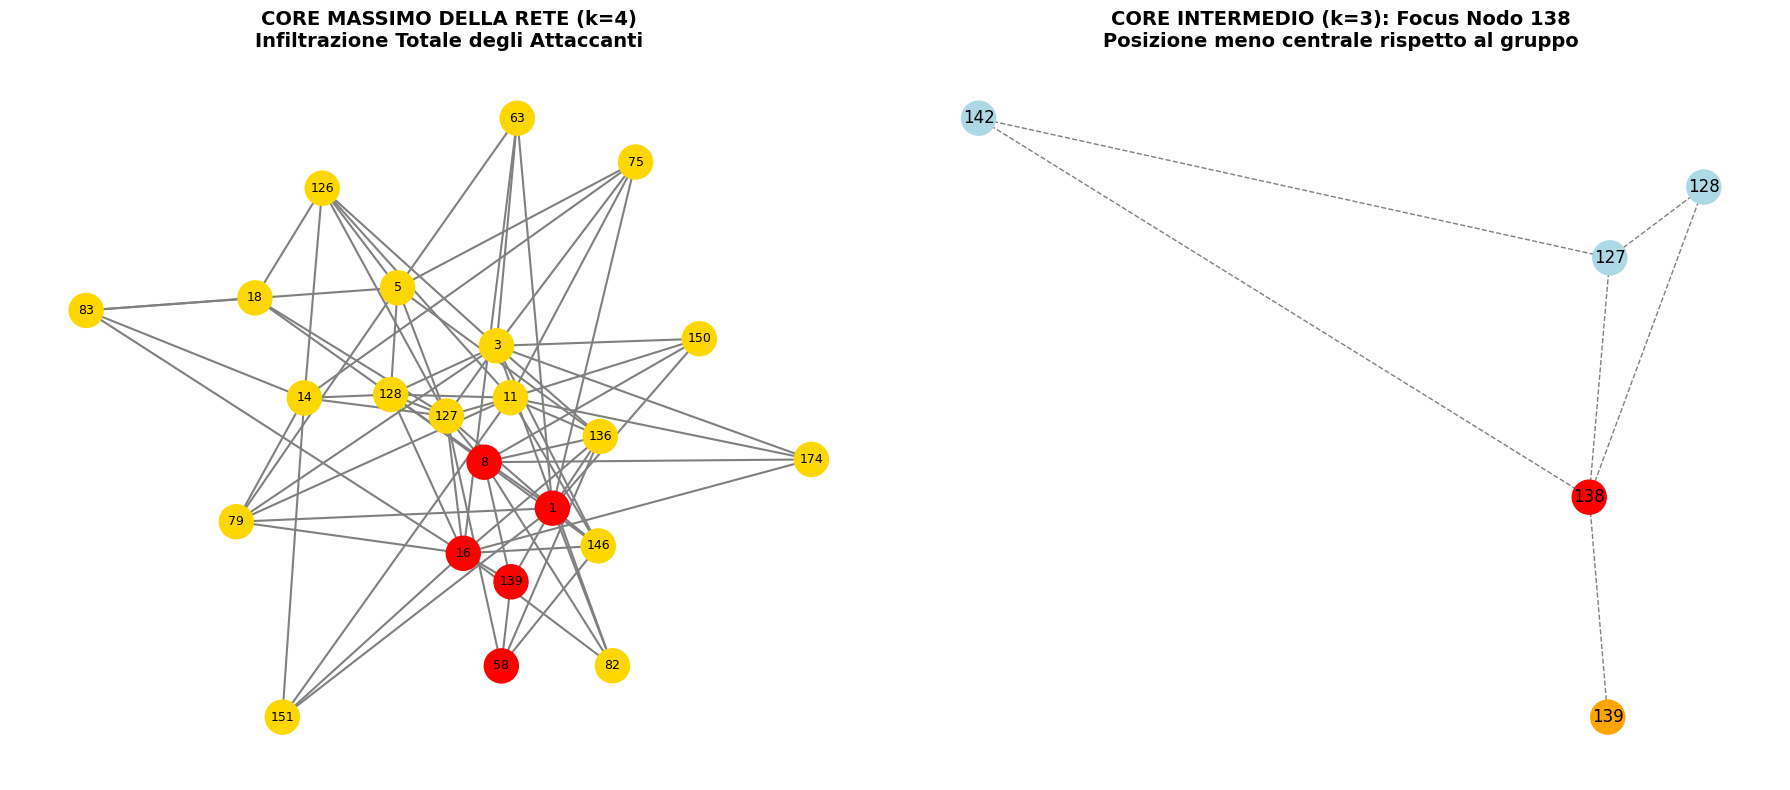

In [ ]:
# Recupero dei dati core
core_numbers = nx.core_number(U)
max_k_network = max(core_numbers.values())  
attaccanti_ids = [58, 139, 16, 8, 1, 138]
set_attaccanti = set(attaccanti_ids)

# Creazione dei sottografi k-core
G_max_core = nx.k_core(U, k=max_k_network)  
G_k3_core = nx.k_core(U, k=3)              

print(f"Core number massimo della rete: {max_k_network}")
print(f"Attaccanti nel core massimo: {[n for n in attaccanti_ids if core_numbers.get(n) == max_k_network]}")

#Visualizzazione Comparativa
fig = plt.figure(figsize=(18, 8))

# Mostra l'intera struttura densa dove risiedono i bot principali
ax1 = plt.subplot(1, 2, 1)
pos1 = nx.spring_layout(G_max_core, seed=42, k=0.5)

node_colors_max = []
for node in G_max_core.nodes():
    if node in set_attaccanti:
        node_colors_max.append("red")
    else:
        node_colors_max.append("gold")

nx.draw(G_max_core, pos1, ax=ax1, with_labels=True, node_size=600, 
        node_color=node_colors_max, edge_color="gray", width=1.5, font_size=9)
ax1.set_title(f"CORE MASSIMO DELLA RETE (k={max_k_network})\nInfiltrazione Totale degli Attaccanti", 
              fontsize=14, fontweight='bold')


ax2 = plt.subplot(1, 2, 2)


nodes_k3 = list(G_k3_core.nodes())

neighbors_138_k3 = [n for n in U.neighbors(138) if core_numbers.get(n) >= 3]
sub_k3 = U.subgraph(neighbors_138_k3 + [138])

pos2 = nx.spring_layout(sub_k3, seed=42)
node_colors_k3 = ["red" if n == 138 else "orange" if n in set_attaccanti else "lightblue" for n in sub_k3.nodes()]

nx.draw(sub_k3, pos2, ax=ax2, with_labels=True, node_size=600, 
        node_color=node_colors_k3, edge_color="gray", style="dashed")
ax2.set_title(f"CORE INTERMEDIO (k=3): Focus Nodo 138\nPosizione meno centrale rispetto al gruppo", 
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

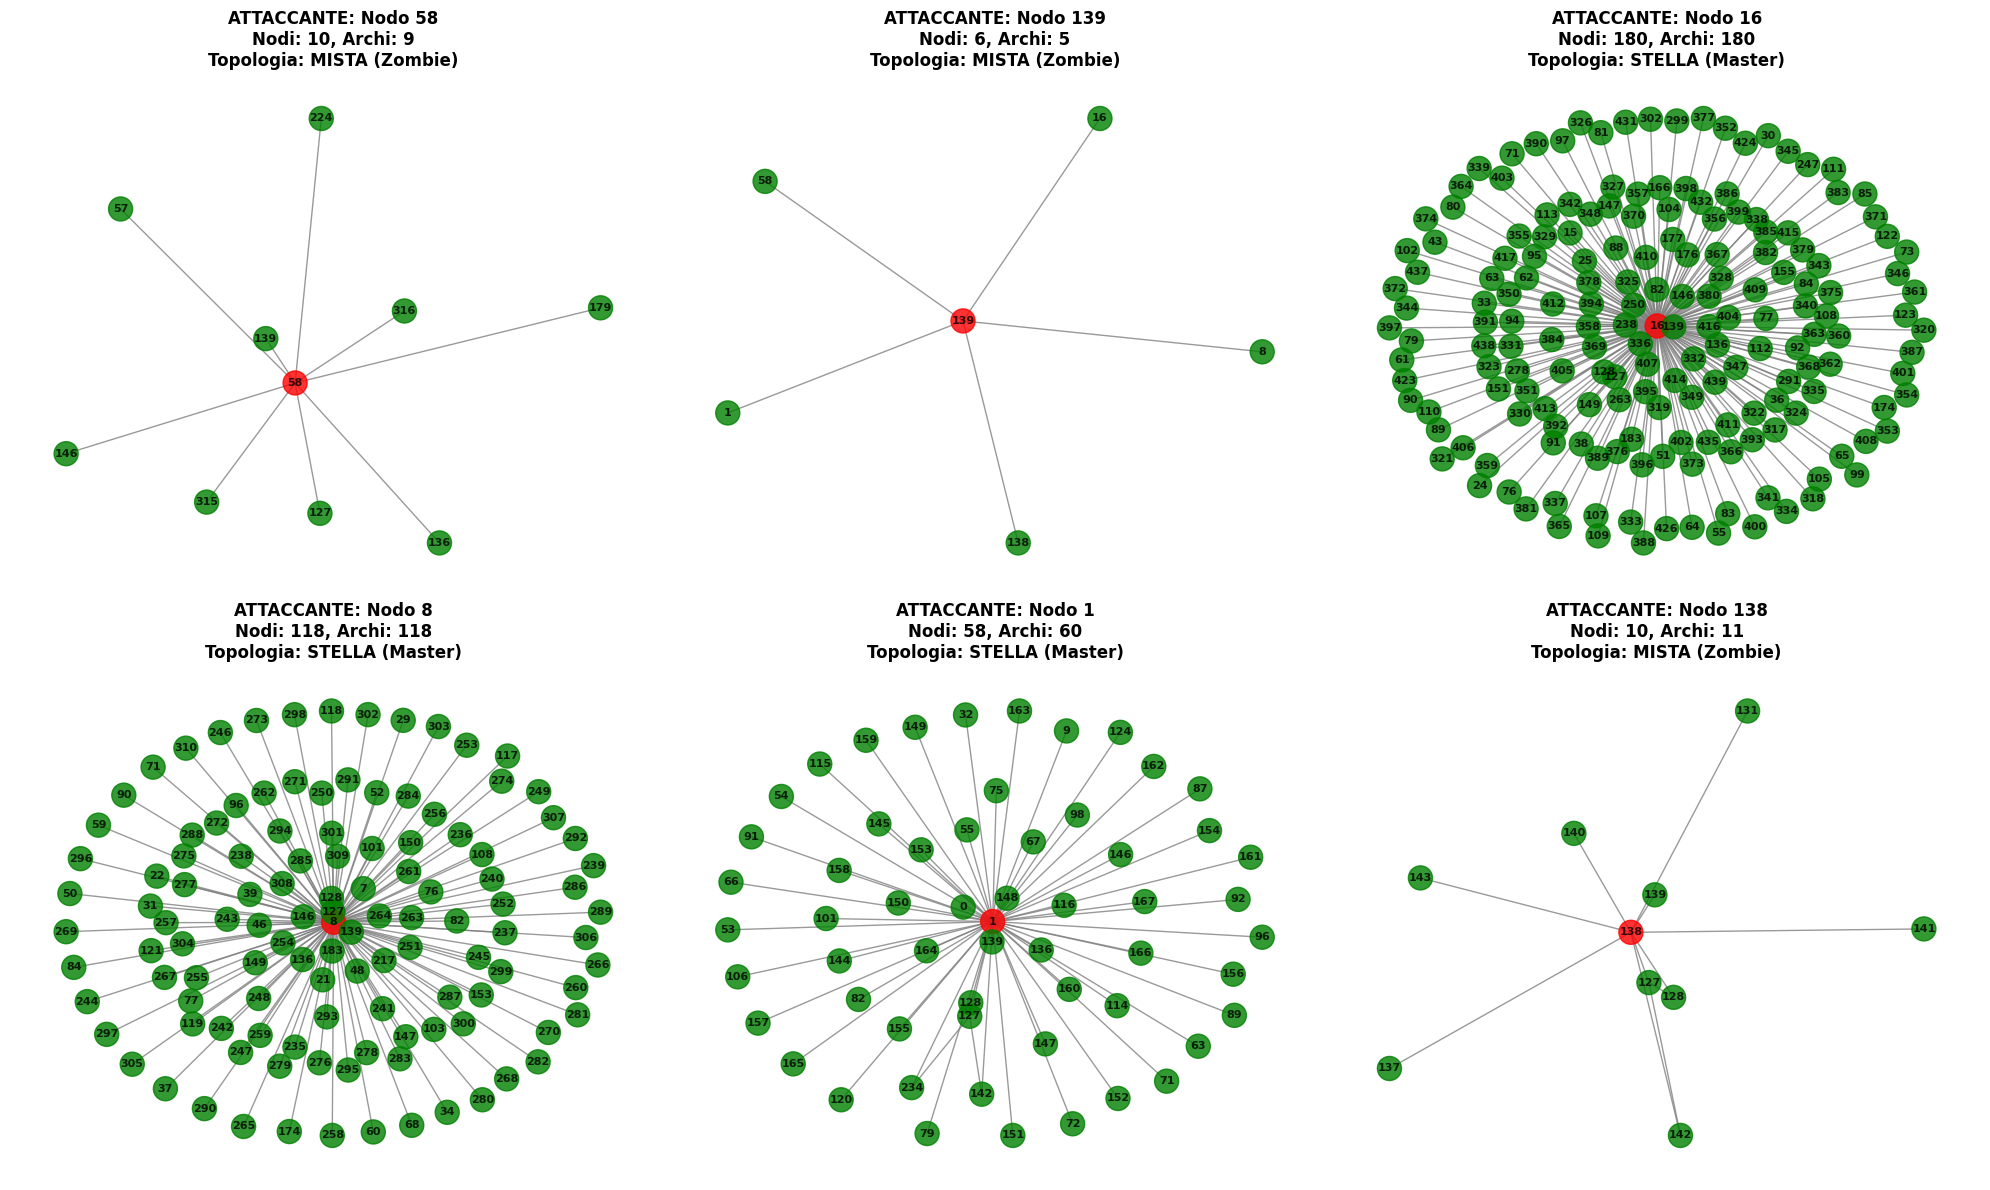

In [ ]:
# Lista degli attaccanti identificati
attaccanti_ids = [58, 139, 16, 8, 1, 138]

# Prepara la figura
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, n in enumerate(attaccanti_ids):
    if n not in U:
        axes[i].set_title(f"Nodo {n}\nNon presente nel grafo")
        axes[i].axis("off")
        continue

    # Generazione Ego-network
    ego = nx.ego_graph(U, n)
    pos = nx.spring_layout(ego, seed=42)

    node_colors = ["red" if node == n else "green" for node in ego.nodes()]
    
    # Disegno del grafo
    nx.draw(
        ego, pos,
        ax=axes[i],
        with_labels=True,
        node_size=300,
        node_color=node_colors,
        edge_color="gray",
        alpha=0.8,
        font_size=8,
        font_weight="bold"
    )
    
    # Diagnosi basata sui dati
    if ego.number_of_nodes() > 20:
        diagnosi = "Topologia: STELLA (Master)"
    else:
        diagnosi = "Topologia: MISTA (Zombie)"

    axes[i].set_title(
        f"ATTACCANTE: Nodo {n}\n"
        f"Nodi: {ego.number_of_nodes()}, Archi: {ego.number_of_edges()}\n"
        f"{diagnosi}",
        fontsize=12, fontweight='bold'
    )
    axes[i].axis("off")

plt.tight_layout()
plt.show()